# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

<h3 style="color:red">IMPORTANTE!</h3>
Durante este notebook se utilizará la librería "skforecast", una librería que contiene las clases y funciones necesarias para adaptar cualquier modelo de regresón de scikit learn a problemas de forecasting. Por lo que antes de seguir debe instalarle utilizando una de las dos opciones:<br/>
pip install skforecast <br/>
pip install skforecast --user

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster



In [2]:
data_2019 = pd.read_csv('Datasets/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('Datasets/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('Datasets/flujo-vehicular-2017.csv', sep =',')

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [6]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

### 2. Normalización de Datasets
Antes de continuar normalizaremos algunos datos de los 3 Datasets<br/>
a) Para 2019, en la instancia "forma_pago" se cambiará el valor de "T. DISCAPACIDAD" por "TARJETA DISCAPACIDAD". <br/>
b) Para 2019, en la instancia "estacion" se cambiará el valor de "Alberti" por "Alberdi". <br/>
c) Para los dataset 2017 y 2018 en la instancia "estacion" de unificará "Dellepiane Centro" y "Dellepiane Liniers" en "Dellepiane".
    

In [10]:
#a) Realizamos el cambio de los datos en la instancia forma_pago para el dataset 2019
data_2019.forma_pago = data_2019.forma_pago.replace({"T. DISCAPACIDAD": 'TARJETA DISCAPACIDAD'})
#b) Realizamos el cambio de los datos en la instancia estacion para el dataset 2019
data_2019.estacion = data_2019.estacion.replace({"Alberti": 'Alberdi'})
#Verificamos que nuestros cambios se hayan realizado correctamente
print(data_2019['forma_pago'].unique())
print(data_2019['estacion'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'TARJETA DISCAPACIDAD']
['Alberdi' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']


In [11]:
#c) A continuación unificaremos los datos de las Estaciones Dellepiane Centro y Dellepiano Liniers en los Dataset 2017 y 2018, para seguir la forma del Dataset 2019
#Para esto crearemos una variable auxiliar filtrada unicamente con las estaciones a unificar, 
#luego en el dataset correspondiente elimanaremos los datos filtrados y uniremos con los datos unificados al Dataset

#Comenzaremos con el Dataset 2017
#Dataset auxiliar df_aux
df_aux = data_2017.copy()
#filtramos
filtrado = np.logical_or(df_aux['estacion']=="Dellepiane Centro",df_aux['estacion']=="Dellepiane Liniers")
df_aux = df_aux.loc[filtrado]
#Agrupamos
df_aux= df_aux.groupby([df_aux['periodo'],df_aux['fecha'],df_aux['hora_inicio'],df_aux['hora_fin'],df_aux['dia'],df_aux['sentido'],df_aux['tipo_vehiculo'],df_aux['forma_pago']],as_index=False)['cantidad_pasos'].sum()
#Añadimos la columna estación con el valor por defecto Dellepiane
df_aux['estacion']="Dellepiane"
#Reordenamos las columnas para seguir el orden del dataset original
df_aux = df_aux[['periodo', 'fecha','hora_inicio','hora_fin','dia','estacion','sentido','tipo_vehiculo','forma_pago','cantidad_pasos']]
print(df_aux.shape)
df_aux

(178485, 10)


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Dellepiane,Centro,Liviano,NO COBRADO,349
1,2017,2017-01-01,0,1,Domingo,Dellepiane,Centro,Liviano,TELEPASE,69
2,2017,2017-01-01,0,1,Domingo,Dellepiane,Centro,Pesado,TELEPASE,11
3,2017,2017-01-01,0,1,Domingo,Dellepiane,Provincia,Liviano,NO COBRADO,278
4,2017,2017-01-01,0,1,Domingo,Dellepiane,Provincia,Liviano,TELEPASE,60
...,...,...,...,...,...,...,...,...,...,...
178480,2017,2017-12-31,23,0,Domingo,Dellepiane,Centro,Pesado,TELEPASE,3
178481,2017,2017-12-31,23,0,Domingo,Dellepiane,Provincia,Liviano,EFECTIVO,3
178482,2017,2017-12-31,23,0,Domingo,Dellepiane,Provincia,Liviano,NO COBRADO,173
178483,2017,2017-12-31,23,0,Domingo,Dellepiane,Provincia,Liviano,TELEPASE,26


In [12]:
#Filtramos para eliminar en el dataset original las variables unificadas en el dataset auxiliar
print(data_2017.shape)
data_2017 = data_2017.loc[filtrado==False]
print(data_2017.shape)
#Concatenamos el dataset original filtrado con el dataset auxiliar
data_2017 = pd.concat([data_2017, df_aux])
#Ordenamos y reiniciamos los indices
data_2017.sort_values(by=['fecha', 'estacion','sentido','tipo_vehiculo','hora_inicio','hora_fin','forma_pago'], inplace = True)
data_2017.reset_index(drop=True, inplace = True)
data_2017

(1372645, 10)
(1015521, 10)


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
...,...,...,...,...,...,...,...,...,...,...
1194001,2017,2017-12-31,7,8,Domingo,Sarmiento,Provincia,Pesado,TELEPASE,1
1194002,2017,2017-12-31,14,15,Domingo,Sarmiento,Provincia,Pesado,TELEPASE,1
1194003,2017,2017-12-31,19,20,Domingo,Sarmiento,Provincia,Pesado,TELEPASE,1
1194004,2017,2017-12-31,21,22,Domingo,Sarmiento,Provincia,Pesado,TELEPASE,1


In [13]:
#Realizamos el mismo proceso para el Dataset 2017 en el Dataset 2018
df_aux = data_2018.copy()
filtrado = np.logical_or(df_aux['estacion']=="Dellepiane Centro",df_aux['estacion']=="Dellepiane Liniers")
df_aux = df_aux.loc[filtrado]
df_aux= df_aux.groupby([df_aux['periodo'],df_aux['fecha'],df_aux['hora_inicio'],df_aux['hora_fin'],df_aux['dia'],df_aux['sentido'],df_aux['tipo_vehiculo'],df_aux['forma_pago']],as_index=False)['cantidad_pasos'].sum()
df_aux['estacion']="Dellepiane"
df_aux = df_aux[['periodo', 'fecha','hora_inicio','hora_fin','dia','estacion','sentido','tipo_vehiculo','forma_pago','cantidad_pasos']]
print(df_aux.shape)
df_aux

(175345, 10)


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Dellepiane,Centro,Liviano,EFECTIVO,3
1,2018,2018-01-01,0,1,Lunes,Dellepiane,Centro,Liviano,NO COBRADO,298
2,2018,2018-01-01,0,1,Lunes,Dellepiane,Centro,Liviano,TELEPASE,73
3,2018,2018-01-01,0,1,Lunes,Dellepiane,Centro,Pesado,TELEPASE,4
4,2018,2018-01-01,0,1,Lunes,Dellepiane,Provincia,Liviano,NO COBRADO,264
...,...,...,...,...,...,...,...,...,...,...
175340,2018,2018-12-31,23,0,Lunes,Dellepiane,Provincia,Liviano,EFECTIVO,1
175341,2018,2018-12-31,23,0,Lunes,Dellepiane,Provincia,Liviano,NO COBRADO,214
175342,2018,2018-12-31,23,0,Lunes,Dellepiane,Provincia,Liviano,TARJETA DISCAPACIDAD,1
175343,2018,2018-12-31,23,0,Lunes,Dellepiane,Provincia,Liviano,TELEPASE,40


In [14]:
data_2018 = data_2018.loc[filtrado==False]
data_2018 = pd.concat([data_2018, df_aux])
data_2018.sort_values(by=['fecha', 'estacion','sentido','tipo_vehiculo','hora_inicio','hora_fin','forma_pago'], inplace = True)
data_2018.reset_index(drop=True, inplace = True)
data_2018

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115
...,...,...,...,...,...,...,...,...,...,...
1197807,2018,2018-12-31,12,13,Lunes,Sarmiento,Provincia,Pesado,TELEPASE,1
1197808,2018,2018-12-31,13,14,Lunes,Sarmiento,Provincia,Pesado,TELEPASE,2
1197809,2018,2018-12-31,17,18,Lunes,Sarmiento,Provincia,Pesado,TELEPASE,1
1197810,2018,2018-12-31,18,19,Lunes,Sarmiento,Provincia,Pesado,TELEPASE,1


Con esto logramos obtener para los 3 datasets que valores categoricos tengan los mismos datos de referencia. 

## 3. Primera Exploración de Datos
Para la primera exploración de datos se trabajará con la estación **Illia** y la forma de pago **Efectivo**


In [15]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [16]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [17]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [18]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Centro,Pesado,1,2017-01-01 00:00:00
2,Domingo,Centro,Pesado,21,2017-01-01 00:00:00
3,Domingo,Centro,Pesado,10,2017-01-01 00:00:00
4,Domingo,Centro,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


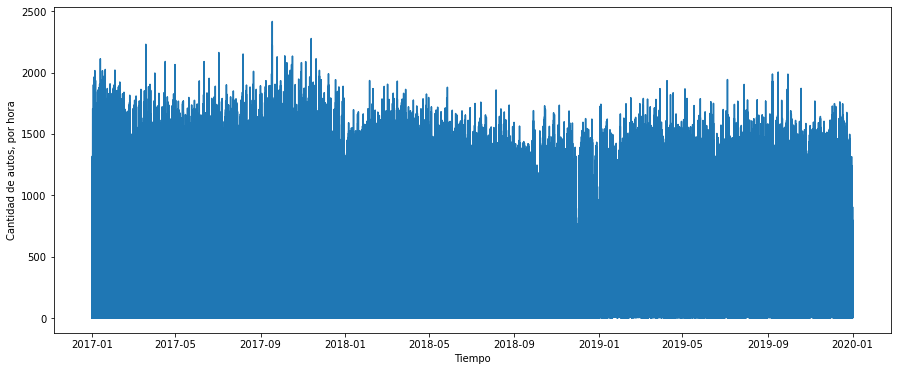

In [19]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [20]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


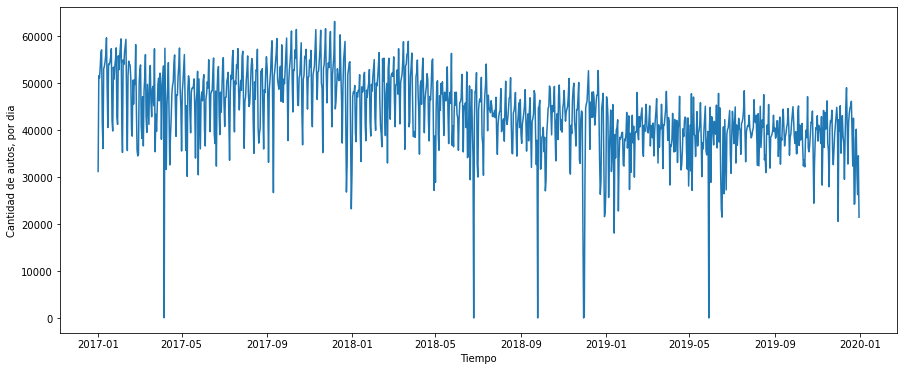

In [21]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

- Para el primer gráfico, Tiempo vs Cantidad de autos por hora, no es posible apreciar alguna tendencia de la Serie de Tiempo.
- Para el segundo gráfico de Tiempo vs/ Cantidad de autos por día, es posible apreciar una tendencia a la disminucación de la cantidad de autos por día en la Estación Illia con método de pago Efectivo.
- Se observan posibibles valores atipicos en algunos días del dataset, esta situación será estudiada en la sección "Valores atipicos"
<br/>
<br/>
Para hacer un analisis más profundo, se resampleará el Dataset para agrupar los datos por semana, con el fin de obtener un versión más limpia del gráfico

In [22]:
#Resampleamos nuestros datos para agrupar por semana
semana = dataset.resample('W', on = 'fecha').sum()
print(semana.shape)
semana.head()

(158, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-08,347212
2017-01-15,366413
2017-01-22,357215
2017-01-29,354581


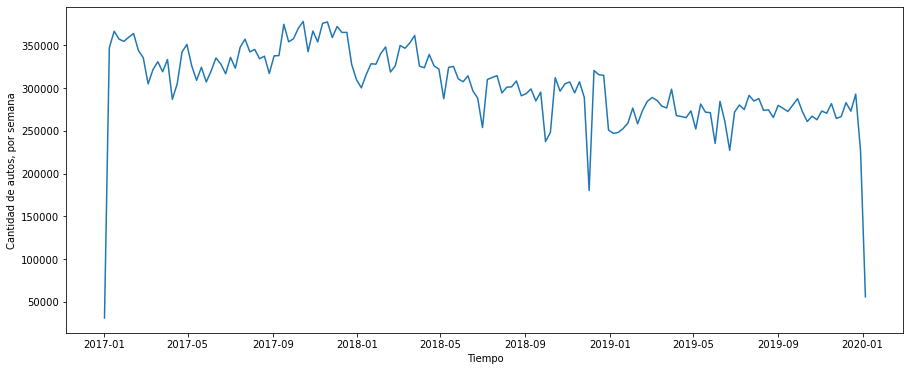

In [23]:
plt.figure(figsize = (15,6))
plt.plot(semana.index, semana.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

- Como se puede apreciar en el gráfico, existe un tendencia negativa en el tiempo en la cantidad de autos para la Estación Illia y método de pago Efectivo.
<br/><br/>
A continuación, se resampleará agrupando los datos por Mes del dataset para obtener una visión más general de la tendencia negativa de los datos 

In [24]:
#Resampleamos nuestros datos para agrupar por mes
mes = dataset.resample('m', on = 'fecha').sum()
print(mes.shape)
mes.head()

(36, 1)


,cantidad_pasos
fecha,
2017-01-31,1565260
2017-02-28,1363113
2017-03-31,1451214
2017-04-30,1373985
2017-05-31,1407136


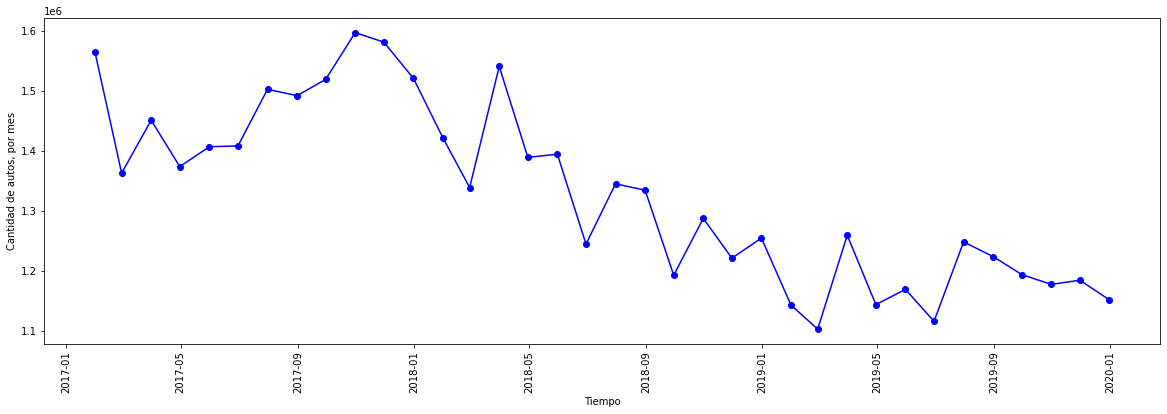

In [25]:
plt.figure(figsize = (20,6))
plt.plot(mes.index, mes.cantidad_pasos,'bo-')
plt.xticks(rotation=90)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por mes')
plt.show()

- Como se puede apreciar en el gráfico, al ver la cantidad de autos por mes se aprecia claramente una tendencia negativa de la Serie, para la Estación Illia y método de pago Efectivo.
- Debido a lo especifico de los datos, ya que se está analizando sólo un método de pago, no se puede concluir que la Estación Illia en general tenga una tendencia negativa. 
- Sólo se puede concluir que el método de pago Efectivo tiene un tendencia negativa en el tiempo para la Estación Illia ¿Tendrán todas las estaciones la misma tendencia para el mismo método de pago?
<br/><br/>
Antes de responder esa pregunta, se analizará el comportamiento de este conjunto de datos para responder las siguientes preguntas.<br/>
a) ¿Cual es el comportamiento durante la semana del tráfico para este Dataset?<br/> 
b) ¿Cual es el comportamiento durante el día del tráfico para este Dataset?<br/>
c) ¿Como se comporta durante la semana en distintos horarios el tráfico para este Dataset?<br/>

In [26]:
#a) ¿Cual es el comportamiento durante la semana del tráfico para este Dataset?<br/> 
#Resampleamos nuestros datos para agrupar por día de la semana
dow=dataset.copy()
dow['fecha'] = pd.to_datetime(dow['fecha'])
dow['dow'] = dow['fecha'].dt.dayofweek
dow['Year'] = dow['fecha'].dt.year
dow= dow.groupby([dow['Year'],dow['dia'],dow['dow']],as_index=False)['cantidad_pasos'].sum()
dow.sort_values('dow', inplace = True)
dow.reset_index(drop=True, inplace = True)
print(dow.shape)
dow.head()

(21, 4)


,Year,dia,dow,cantidad_pasos
0,2017,Lunes,0,2491296
1,2019,Lunes,0,1965775
2,2018,Lunes,0,2234316
3,2018,Martes,1,2295457
4,2017,Martes,1,2539269


<AxesSubplot:xlabel='dia', ylabel='cantidad_pasos'>

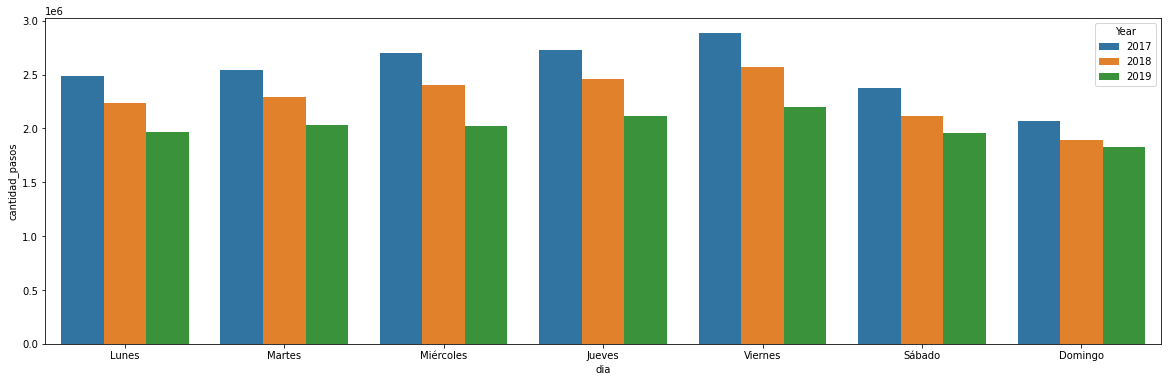

In [27]:
import seaborn as sns
plt.figure(figsize = (20,6))

sns.barplot(x="dia", y="cantidad_pasos", hue="Year", data=dow)

Del gráfico podemos apreciar que <br/>
- El día de la semana donde hay más trafico vehicular es el día Viernes, existiendo una baja para el fin de semana.
- Existe una autocorrelación entre los días laborales, correlativos, en el tráfico vehicular.
- Se puede apreciar la tendencia negativa anual de la serie para el pago en efectivo.

In [28]:
#b) ¿Cual es el comportamiento durante el día del tráfico para este Dataset?<br/>
#Resampleamos nuestros datos para agrupar por hora
hour=dataset.copy()
hour['fecha'] = pd.to_datetime(hour['fecha'])
hour['hour'] = hour['fecha'].dt.hour
hour['Year'] = hour['fecha'].dt.year
hour= hour.groupby([hour['Year'],hour['hour']],as_index=False)['cantidad_pasos'].sum()
hour.sort_values('hour', inplace = True)
hour.reset_index(drop=True, inplace = True)
print(hour.shape)
hour.head()

(72, 3)


,Year,hour,cantidad_pasos
0,2017,0,384215
1,2019,0,313794
2,2018,0,359132
3,2017,1,317703
4,2019,1,263432


<AxesSubplot:xlabel='hour', ylabel='cantidad_pasos'>

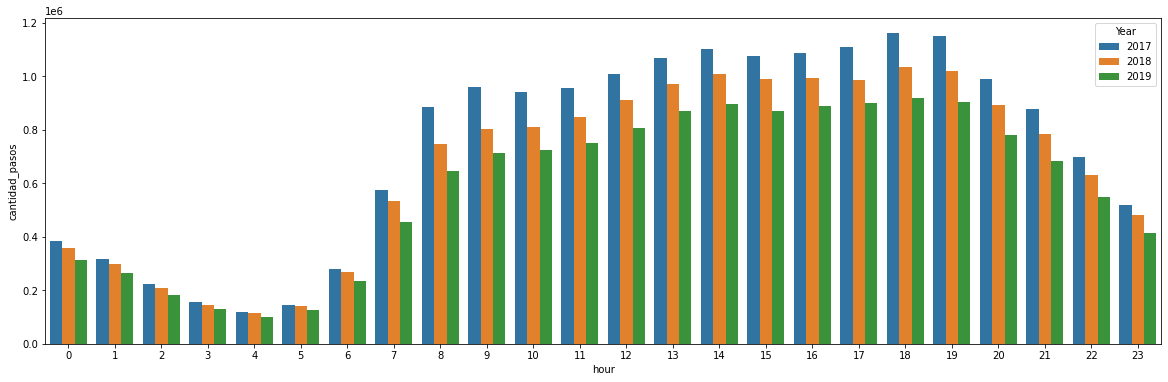

In [29]:
plt.figure(figsize = (20,6))
sns.barplot(x="hour", y="cantidad_pasos", hue="Year", data=hour)

Del gráfico podemos apreciar que:<br/>
- El horario peak de tráfico vehicular es entre las 18 y 19 horas. Mientras que el horario valle se produce entre las 3 y 5 de las mañana.
- Se puede observar el comportamiento de la ciudad, comenzando su despertar con un alza significativa desde las 6am hasta las 8am. Para luego disminuir progresivamente desde las 20horas.
- También se puede apreciar la tendencia negativa anual de la serie para el pago en efectivo.

In [30]:
#c) ¿Como se comporta durante la semana en distintos horarios el tráfico para este Dataset?
#Resampleamos nuestros datos para agrupar por día de la semana y hora
hdow=dataset.copy()
hdow['fecha'] = pd.to_datetime(hdow['fecha'])
hdow['dow'] = hdow['fecha'].dt.dayofweek
hdow['hour'] = hdow['fecha'].dt.hour
hdow['Year'] = hdow['fecha'].dt.year
hdow= hdow.groupby([hdow['Year'],hdow['dia'],hdow['dow'],hdow['hour']],as_index=False)['cantidad_pasos'].sum()
hdow.sort_values(['dow','hour'], inplace = True)
hdow.reset_index(drop=True, inplace = True)
print(hdow.shape)
hdow.head()

(504, 5)


,Year,dia,dow,hour,cantidad_pasos
0,2017,Lunes,0,0,43036
1,2018,Lunes,0,0,40919
2,2019,Lunes,0,0,36697
3,2017,Lunes,0,1,43205
4,2018,Lunes,0,1,42139


<AxesSubplot:title={'center':'Año 2019'}, xlabel='hour', ylabel='cantidad_pasos'>

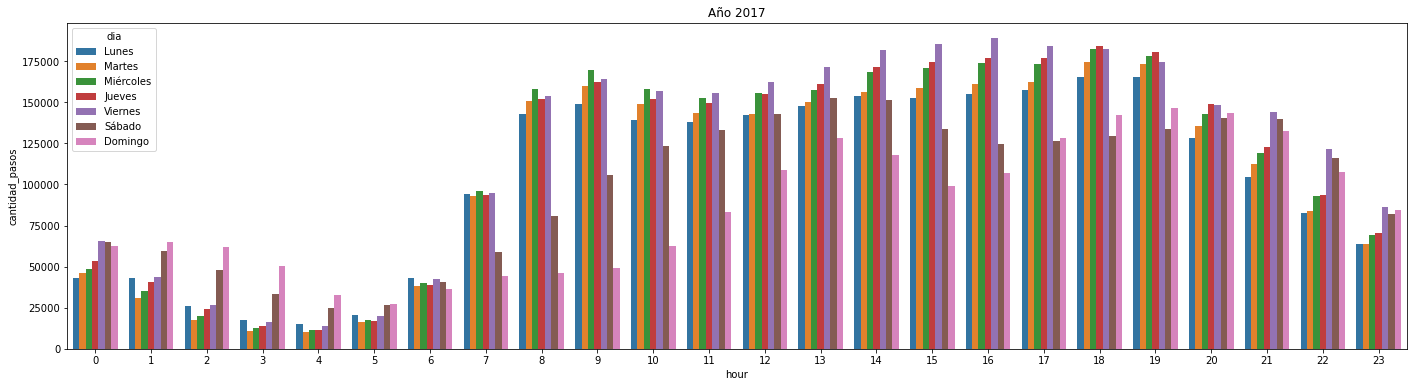

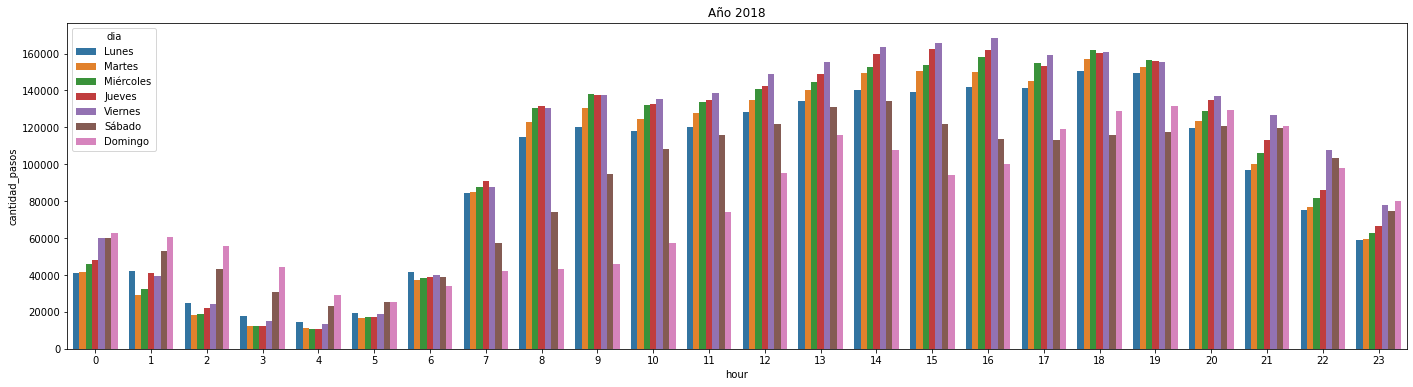

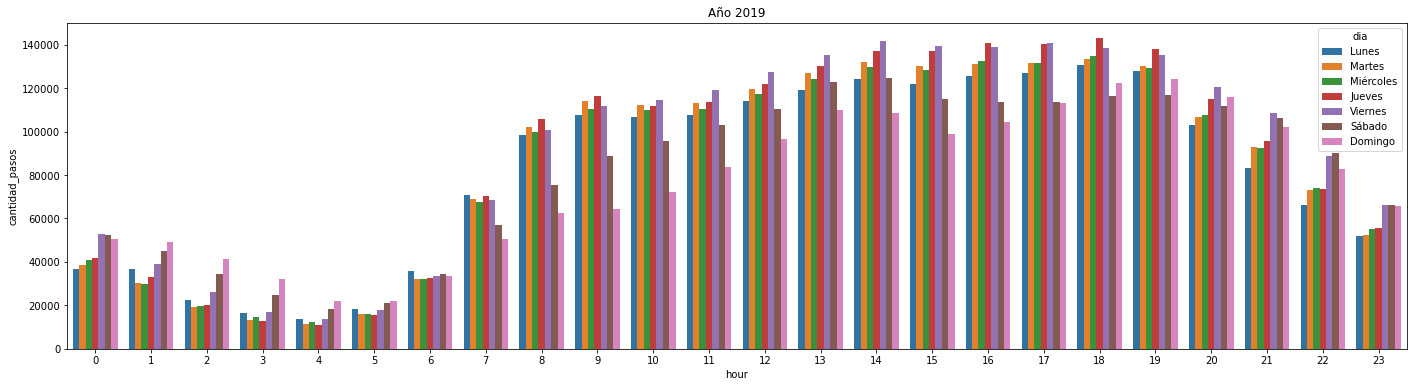

In [31]:
filtrado = (hdow['Year']==2017)
hdow_2017 = hdow.loc[filtrado]
filtrado = (hdow['Year']==2018)
hdow_2018 = hdow.loc[filtrado]
filtrado = (hdow['Year']==2019)
hdow_2019 = hdow.loc[filtrado]
plt.figure(figsize = (24,6))
plt.title('Año 2017')
sns.barplot(x="hour", y="cantidad_pasos", hue="dia",data=hdow_2017)
plt.figure(figsize = (24,6))
plt.title('Año 2018')
sns.barplot(x="hour", y="cantidad_pasos", hue="dia",data=hdow_2018)
plt.figure(figsize = (24,6))
plt.title('Año 2019')
sns.barplot(x="hour", y="cantidad_pasos", hue="dia",data=hdow_2019)

De los tres gráficos podemos concluir que:<br/>
- Diariamente el horario peak de tráfico vehicular, durante la semana laboral (lunes a jueves, exceptuando el viernes) es entre las 18 y 19 horas.
- En general el día viernes, ad-portas del fin de semana, presenta un alza respecto a los otros días desde el medio día. Apreciandose esta misma alza para los años 2018 y 2019 para el día Jueves. Teniendo una fuerte baja los días Sábado y Domingo durante el día. 
- Para el fin de semana, viernes incluido, se aprecia un alza durante desde las 21 horas respecto a los demás dias de la semana, terminando a las 4 de la madrugada del Domingo.

## 4. Valores atipicos 
Como se pudo observa, anteriormente, en el gráfico de Cantidad de autos por día, existen valores atipicos en nuestro dataset. Al analizar con más detalle el gráfico se puede observar que existen algunos días donde la cantidad de pasos es 0 para el tipo de pago efectivo.

A continuación se volverá a graficar el dataset y se buscará los días donde la cantidad de paso sea menos a 10000.

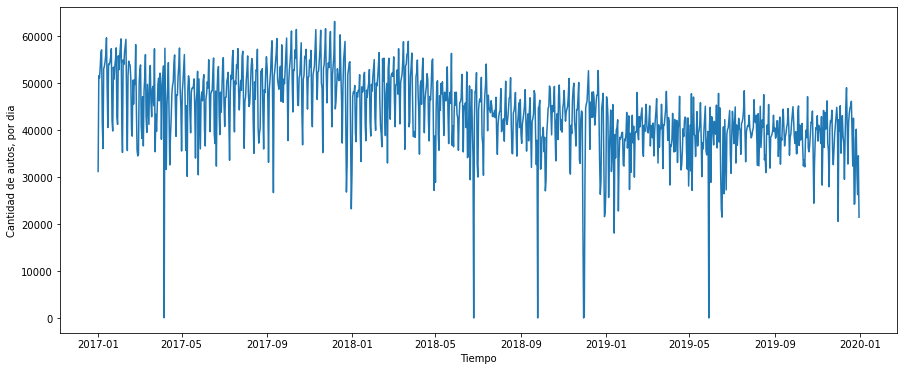

In [32]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [33]:
#Cantidad de pasos menos a 10000
print('Días donde la cantidad de pasos es menor a 1000')
diario = dataset.resample('D', on = 'fecha').sum()
diario_aux= diario.loc[diario.cantidad_pasos<1000]
diario_aux

Días donde la cantidad de pasos es menor a 1000


,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-30,0
2018-12-01,350
2019-05-29,0


Esta situación provocará un problema al querer hacer una buena predicción, por lo que se debe analizar con más detalle el dataset en estos días, respondiendo las siguientes preguntas:
- ¿Que ocurre en estos días para los otros medios de pago para la Estación Illia?
- ¿Que provocó la baja en la cantidad de pasos?
Para responder estas preguntas se realizará una nueva versión del dataset con todas las formas de pago para la estación "Illia". Luego se buscará la cantidad de pasos por forma de pago para los días con pasos menores a mil.

In [34]:
#Volvemos a unir los 3 datasets,
ds = pd.concat([data_2019, data_2018, data_2017])
#Esta vez nos quedamos solamente con la estación Illia
mask = (ds.estacion=='Illia')
ds = ds[mask]
#Quitamos las columnas que no vamos a utilizar
ds.drop(columns = ['periodo','hora_inicio', 'estacion'], inplace = True)
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
ds['fecha2'] = pd.to_datetime(ds.fecha) + pd.to_timedelta(ds.hora_fin, unit = 'h')
#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
ds.drop(columns=['fecha','hora_fin'], inplace = True)
#Corregimos el nombre de fecha2 a fecha
ds.rename(columns = {'fecha2':'fecha'}, inplace = True) 
#Reordenamos el dataset por fecha
ds.sort_values('fecha', inplace = True)
ds.reset_index(drop=True, inplace = True)
ds

,dia,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
0,Domingo,Centro,Pesado,EFECTIVO,1,2017-01-01 00:00:00
1,Domingo,Provincia,Pesado,TELEPASE,7,2017-01-01 00:00:00
2,Domingo,Provincia,Pesado,TELEPASE,3,2017-01-01 00:00:00
3,Domingo,Provincia,Liviano,TARJETA DISCAPACIDAD,4,2017-01-01 00:00:00
4,Domingo,Provincia,Liviano,TELEPASE,275,2017-01-01 00:00:00
...,...,...,...,...,...,...
752547,Martes,Centro,Liviano,TELEPASE,122,2019-12-31 23:00:00
752548,Martes,Centro,Liviano,NO COBRADO,3,2019-12-31 23:00:00
752549,Martes,Centro,Liviano,INFRACCION,4,2019-12-31 23:00:00
752550,Martes,Centro,Liviano,EXENTO,1,2019-12-31 23:00:00


In [35]:
diario_ds=ds.copy()
diario_ds['fecha'] = diario_ds['fecha'].dt.strftime('%Y-%m-%d')
diario_ds= diario_ds.groupby([diario_ds['fecha'],diario_ds['forma_pago']],as_index=False)['cantidad_pasos'].sum()
for i in diario_aux.index:
    #print(i.strftime('%Y-%m-%d'))
    print('- Tráfico por forma de pago para Fecha ',i.strftime('%Y-%m-%d'))
    print(diario_ds[diario_ds.fecha==i.strftime('%Y-%m-%d')],'\n')


- Tráfico por forma de pago para Fecha  2017-04-06
          fecha  forma_pago  cantidad_pasos
573  2017-04-06    EFECTIVO              40
574  2017-04-06      EXENTO               1
575  2017-04-06  NO COBRADO           45961
576  2017-04-06    TELEPASE           19296 

- Tráfico por forma de pago para Fecha  2018-06-25
           fecha  forma_pago  cantidad_pasos
3241  2018-06-25  NO COBRADO           85099 

- Tráfico por forma de pago para Fecha  2018-09-25
           fecha  forma_pago  cantidad_pasos
3788  2018-09-25  NO COBRADO           78690 

- Tráfico por forma de pago para Fecha  2018-11-30
           fecha  forma_pago  cantidad_pasos
4179  2018-11-30  NO COBRADO             387 

- Tráfico por forma de pago para Fecha  2018-12-01
           fecha            forma_pago  cantidad_pasos
4180  2018-12-01              EFECTIVO             350
4181  2018-12-01                EXENTO               9
4182  2018-12-01            INFRACCION               5
4183  2018-12-01           

- Como se puede observar de los datos, en general la situación tiende a repetirse para todos los medios de pagos, excepto para el 2017-04-06, donde solo efectivo tuvo una bajo, mientras que telepase se mantuvo por sobre las 15000. Al realizar una busqueda en internet, se obtiene que todos estos días fueron días de paros en el país.
- Aun que los datos de la forma de pago "No Cobrado" pudiesen contener los datos del tráfico vehicular del día, no queda claro si esto es real, por lo que se hace necesario realizar una corrección en nuestro dataset, en estos días, con el fin de realizar una mejor predicción.

## 5. Tendencia
Antes de comenzar la corrección de los datos atipicos, verifaremos si la tendencia negativa de los datos se mantiene con este nuevo dataset.

In [36]:
#Resampleamos nuestros datos para agrupar por semana
semana_ds = ds.groupby('forma_pago').apply(lambda x: x.set_index('fecha').resample('W').sum()).reset_index()
semana_dst = ds.resample('W', on = 'fecha').sum()
print(semana_ds.shape)
semana_ds

(950, 3)


,forma_pago,fecha,cantidad_pasos
0,EFECTIVO,2017-01-01,31183
1,EFECTIVO,2017-01-08,347212
2,EFECTIVO,2017-01-15,366413
3,EFECTIVO,2017-01-22,357215
4,EFECTIVO,2017-01-29,354581
...,...,...,...
945,TELEPASE,2019-12-08,399201
946,TELEPASE,2019-12-15,357831
947,TELEPASE,2019-12-22,407208
948,TELEPASE,2019-12-29,282395


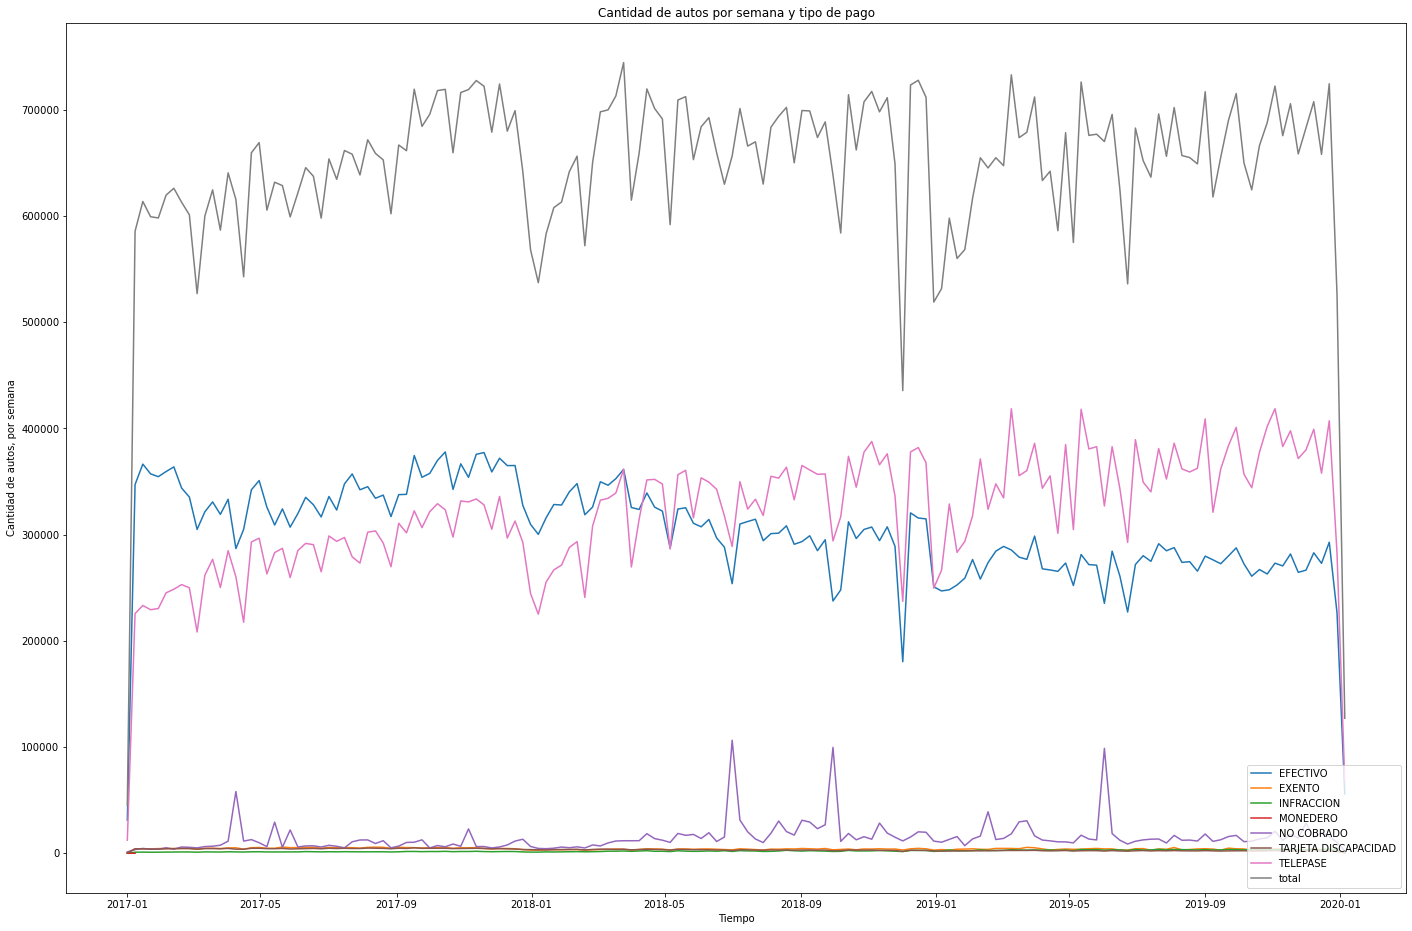

In [37]:
semana_ds_unique=semana_ds['forma_pago'].unique()
plt.figure(figsize = (24,16))
for i in semana_ds_unique:
    plt.plot(semana_ds[semana_ds['forma_pago']==i].fecha, semana_ds[semana_ds['forma_pago']==i].cantidad_pasos,label=i)
plt.plot(semana_dst.index, semana_dst.cantidad_pasos,label="total")  
plt.title('Cantidad de autos por semana y tipo de pago')
plt.legend(loc='lower right')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()
#plt.figure(figsize = (24,8))
#plt.title('Cantidad de autos por semana totales')
#plt.xlabel('Tiempo')
#plt.ylabel('Cantidad de autos, por semana')
#plt.show()

- Del gráfico se puede observar que la forma de pago 'Efectivo' tiene una tendencia negativa, mientras que la forma de pago 'Telepase' tiene una tendencia positiva, por lo que podemos concluir que existe una migración en la forma de pago en la estación.

## 6. Componente Estacional
Se procederá a buscar componentes estacionales de la serie de tiempo para estación 'Illia' con todas las formas de pago, comparando también con los datos obtenidos sólo para el método de pago "Efectivo". Se realizará un resampleo por meses, agrupaciones por días de la semana y horas del día.

#### Estacionalidad Anual


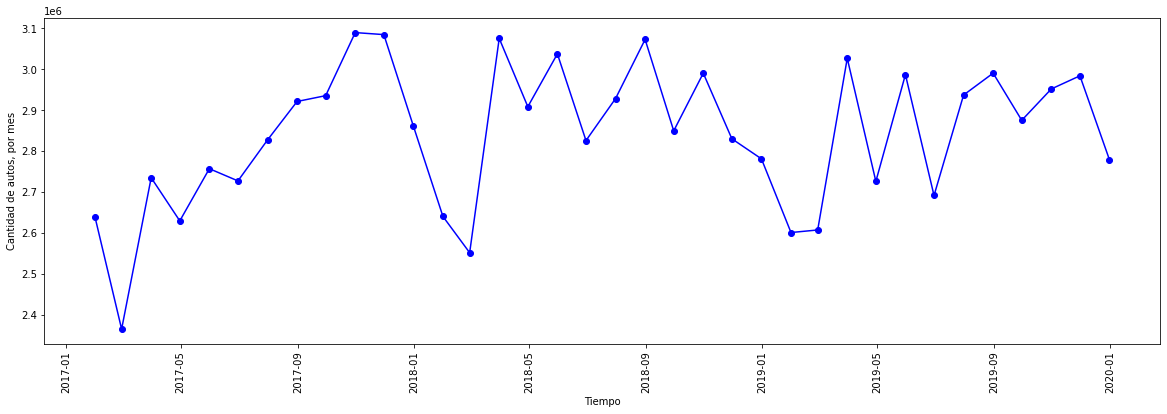

In [38]:
#Se realiza resample y gráfico por meses de la serie de tiempo
mes_ds = ds.resample('m', on = 'fecha').sum()
plt.figure(figsize = (20,6))
plt.plot(mes_ds.index, mes_ds.cantidad_pasos,'bo-')
plt.xticks(rotation=90)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por mes')
plt.show()

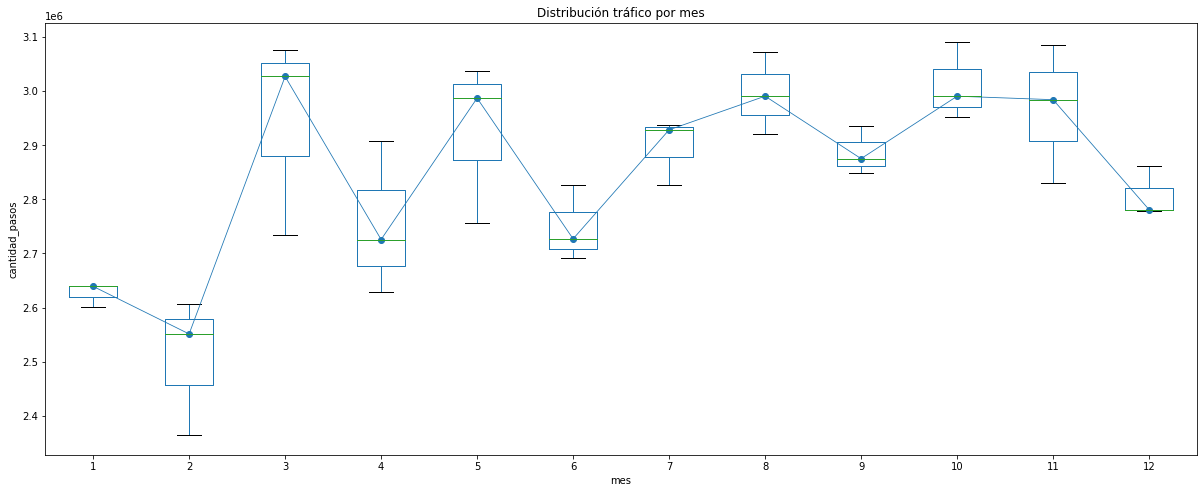

In [39]:
# Gráfico boxplot para estacionalidad anual
fig, ax = plt.subplots(figsize=(20,8))
mes_ds['mes'] = mes_ds.index.month
mes_ds.boxplot(column='cantidad_pasos', by='mes', ax=ax,)
mes_ds.groupby('mes')['cantidad_pasos'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('cantidad_pasos')
ax.set_title('Distribución tráfico por mes')
fig.suptitle('');

- De los gráficos se puede apreciar que existe una componente estacional a la baja durante los meses de verano, Enero y Febrero. 
- En comparación con el gráfico obtenido para el método de pago "Efectivo", donde se podía apreciar la tendencia negativa del mismo, no era posible observar la actual componente estacional.

##### Estacionalidad Semanal

<AxesSubplot:xlabel='dia', ylabel='cantidad_pasos'>

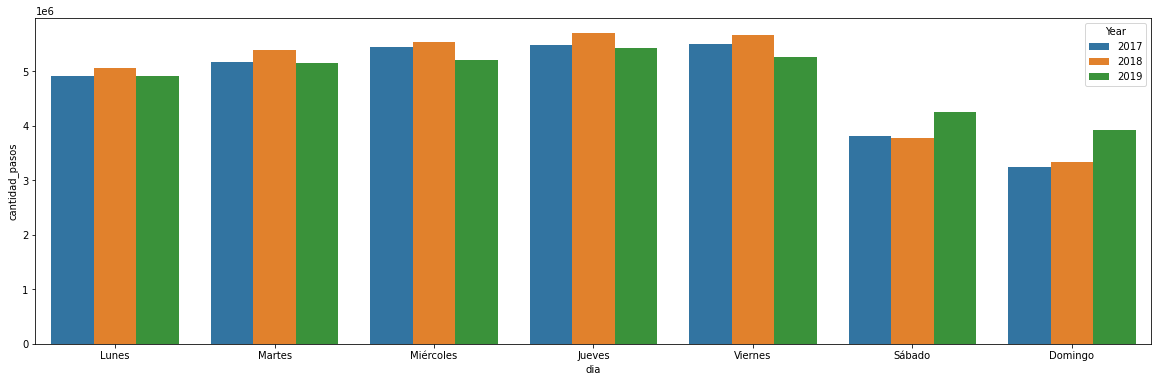

In [40]:
#Se realiza agrupación por días de la semana y se gráfica
ds_dow=ds.copy()
ds_dow['fecha'] = pd.to_datetime(ds_dow['fecha'])
ds_dow['dow'] = ds_dow['fecha'].dt.dayofweek
ds_dow['Year'] = ds_dow['fecha'].dt.year
ds_dow= ds_dow.groupby([ds_dow['Year'],ds_dow['dia'],ds_dow['dow']],as_index=False)['cantidad_pasos'].sum()
ds_dow.sort_values('dow', inplace = True)
ds_dow.reset_index(drop=True, inplace = True)
ds_dow.head()
plt.figure(figsize = (20,6))
sns.barplot(x="dia", y="cantidad_pasos", hue="Year", data=ds_dow)

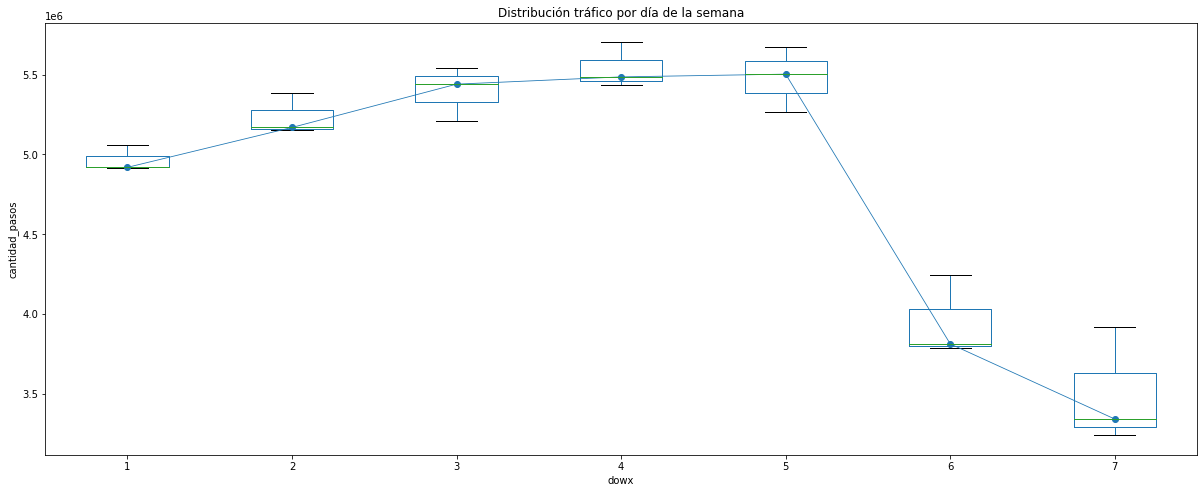

In [41]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 8))
ds_dow['dowx'] = ds_dow.dow + 1
ds_dow.boxplot(column='cantidad_pasos', by='dowx', ax=ax)
ds_dow.groupby('dowx')['cantidad_pasos'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('cantidad_pasos')
ax.set_title('Distribución tráfico por día de la semana')
fig.suptitle('');

- Como se puede apreciar en los gráficos, en comparación con el mismo gráfico obtenido solo para el método de pago "Efectivo", la componente semanal estacional se mantiene. En general, durante los fines de semana el tráfico disminuye.

<AxesSubplot:xlabel='hour', ylabel='cantidad_pasos'>

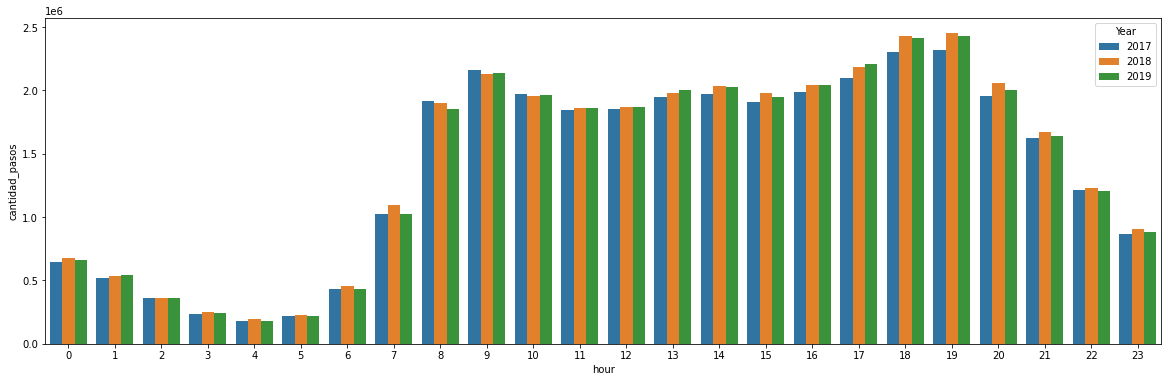

In [42]:
#Se realiza agrupación por horas del día y se gráfica
ds_hour=ds.copy()
ds_hour['fecha'] = pd.to_datetime(ds_hour['fecha'])
ds_hour['hour'] = ds_hour['fecha'].dt.hour
ds_hour['Year'] = ds_hour['fecha'].dt.year
ds_hour= ds_hour.groupby([ds_hour['Year'],ds_hour['hour']],as_index=False)['cantidad_pasos'].sum()
ds_hour.sort_values('hour', inplace = True)
ds_hour.reset_index(drop=True, inplace = True)
plt.figure(figsize = (20,6))
sns.barplot(x="hour", y="cantidad_pasos", hue="Year", data=ds_hour)

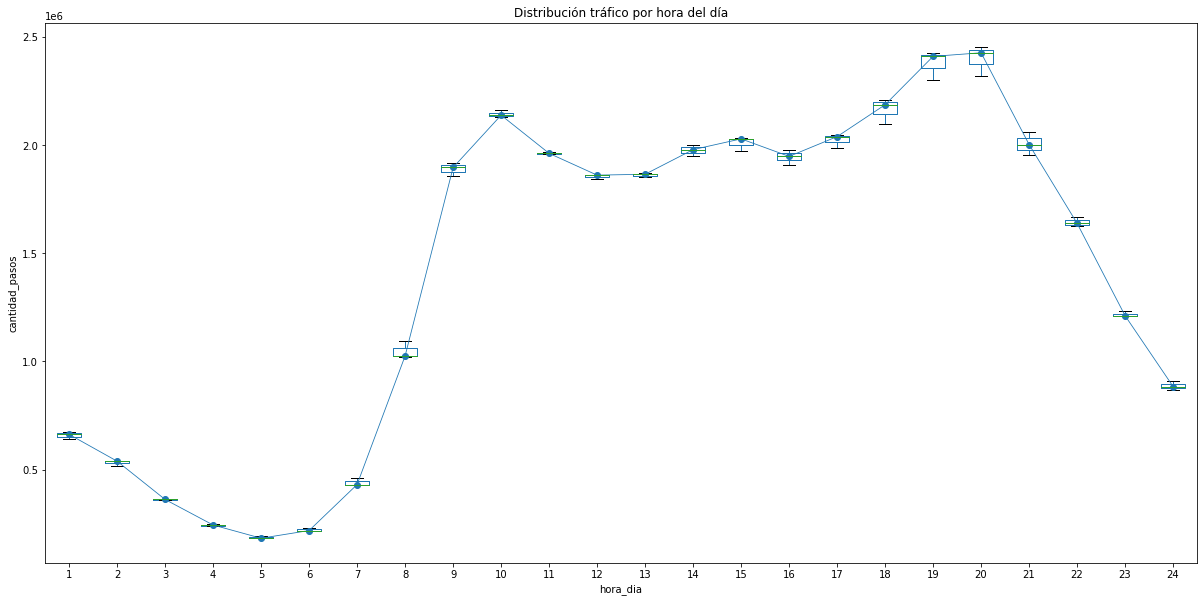

In [43]:
# Gráfico boxplot para estacionalidad diaria
fig, ax = plt.subplots(figsize=(20, 10))
ds_hour['hora_dia'] = ds_hour.hour + 1
ds_hour.boxplot(column='cantidad_pasos', by='hora_dia', ax=ax)
ds_hour.groupby('hora_dia')['cantidad_pasos'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('cantidad_pasos')
ax.set_title('Distribución tráfico por hora del día')
fig.suptitle('');

- En comparación con el mismo gráfico obtenido solo para el método de pago "Efectivo", se observa que también la componente estacional diaria se mantiene. Con horas pico entre las 18 y 20horas, con una fuerte baja desde las 21 horas y un minimo entre las 3am y 7am.
- En general la serie, tanto para el tráfico de días de la semana y horas del día, se mantiene similar a la serie para el método de pago "Efectivo".

## 7. Corrección de valores atipicos
Se definirá una función de corrección utilizando una media movil que calculará un nuevo valor para el tráfico vehicular atipico utilizando los 4 ultimos datos del dataset para el día de la semana que corresponda. Se definirá un valor minimo de corte.

In [44]:
def correccion(ds,minimo):
    ds['fecha'] = pd.to_datetime(ds['fecha'])
    ds['fecha2'] = ds['fecha'].dt.strftime('%Y-%m-%d')
    ds['Year'] = ds['fecha'].dt.year
    ano_minimo = str(min(ds['Year']))+'-01-01'
    ano_minimo = datetime.datetime.strptime(ano_minimo,"%Y-%m-%d")
    ano_maximo = str(max(ds['Year']))+'-12-31'
    ano_maximo = datetime.datetime.strptime(ano_maximo,"%Y-%m-%d")
    #Resampleamos nuestros datos para agrupar por dia y forma de pago
    ds_dia = ds.groupby('forma_pago').apply(lambda x: x.set_index('fecha').resample('D').sum()).reset_index()
    ds_dia.sort_values(['fecha'], inplace = True)
    ds_dia.reset_index(drop=True, inplace = True)
    ds_dia.drop(columns=['Year'], inplace = True)

    #filtramos para obtener las fechas donde la forma de pago efectivo o telepase sean menores al minimo
    filtro1=np.logical_and(ds_dia['forma_pago']=="EFECTIVO",ds_dia.cantidad_pasos < minimo)
    filtro2=np.logical_and(ds_dia['forma_pago']=="TELEPASE",ds_dia.cantidad_pasos < minimo)
    ds_dia_e = ds_dia.loc[filtro1]
    print('- Valores atipicos para forma de pago: Efectivo: \n')
    print(ds_dia_e)
    print('\n')
    
    ds_dia_t = ds_dia.loc[filtro2]    
    print('- Valores atipicos para forma de pago: Telepase: \n')
    print(ds_dia_t)
    print('\n')
    
    #unimos las dos series a través de la fecha
    ds_dia_aux= pd.merge(ds_dia_e, ds_dia_t, how='outer', on=['fecha'])
    ds_dia_aux.sort_values(['fecha'], inplace = True)
    ds_dia_aux.reset_index(drop=True, inplace = True)
    #filtramos para eliminar las fechas donde la forma de pago efectivo o telepase sean menores al minimo
    for i in ds_dia_aux.values:
        #print('Borrando Fecha: ',i[1].strftime('%Y-%m-%d'),'\n')
        filtro_borrar = (ds['fecha'].dt.strftime('%Y-%m-%d')==i[1].strftime('%Y-%m-%d'))
        ds = ds.loc[filtro_borrar==False]        
    #resampleamos el data set por día
    diario= ds.groupby([ds['fecha2']],as_index=False)['cantidad_pasos'].sum()
    diario['fecha2'] = pd.to_datetime(diario['fecha2'])
    diario.rename(columns = {'fecha2':'fecha'}, inplace = True) 
    #buscamos las fechas no existentes 
    fechas_no=pd.date_range(start=ano_minimo, end=ano_maximo).difference(diario.fecha)
    print('- Resumen Fechas Valores atipicos y Fechas faltantes para corrección: \n')
    print(fechas_no.strftime('%Y-%m-%d'))
    print('\n')

    diario= ds.groupby([ds['fecha2']],as_index=False)['cantidad_pasos'].sum()
    for i in fechas_no:
        contador = 0
        cantidad = 0
        for x in range(4):
            dias_atras = (x+1)*(-7)
            fecha_atras = pd.to_datetime(i.strftime('%Y-%m-%d')) + pd.DateOffset(days=dias_atras)
            fecha_atras = fecha_atras.strftime('%Y-%m-%d')
            if fecha_atras in diario.fecha2.values:
                aux_diario = diario.loc[diario.fecha2==fecha_atras]
                cantidad = cantidad + aux_diario.cantidad_pasos.values[0]
                contador = contador + 1                
        if (contador<4):
            for x in range(4-contador):
                dias_atras = (x+1)*(7)
                fecha_adelante = pd.to_datetime(i.strftime('%Y-%m-%d')) + pd.DateOffset(days=dias_atras)
                fecha_adelante = fecha_adelante.strftime('%Y-%m-%d')
                if fecha_adelante in diario.fecha2.values:
                    aux_diario = diario.loc[diario.fecha==fecha_adelante]
                    cantidad = cantidad + aux_diario.cantidad_pasos.values[0]
                    contador = contador + 1
        cantidad = round(cantidad / contador)
        fechax = pd.to_datetime(i)
        new_row = {'dia':i.day_name(locale ='Spanish'), 'sentido':'N/A', 'tipo_vehiculo':'N/A', 'forma_pago':'TODAS','cantidad_pasos':cantidad,'fecha':fechax,'fecha2':fechax.strftime('%Y-%m-%d'),'Year':fechax.year}
        ds = ds.append(new_row, ignore_index=True)
        ds.sort_values(['fecha'], inplace = True)
        ds.reset_index(drop=True, inplace = True)
    return ds

In [45]:
dsx = correccion(ds,1000)
dsx

- Valores atipicos para forma de pago: Efectivo: 

     forma_pago      fecha  cantidad_pasos
578    EFECTIVO 2017-04-06              40
3247   EFECTIVO 2018-06-25               0
3799   EFECTIVO 2018-09-25               0
4194   EFECTIVO 2018-11-30               0
4198   EFECTIVO 2018-12-01             350
5272   EFECTIVO 2019-05-29               0


- Valores atipicos para forma de pago: Telepase: 

     forma_pago      fecha  cantidad_pasos
3244   TELEPASE 2018-06-25               0
3800   TELEPASE 2018-09-25               0
4195   TELEPASE 2018-11-30               0
4199   TELEPASE 2018-12-01             290
5273   TELEPASE 2019-05-29               0


- Resumen Fechas Valores atipicos y Fechas faltantes para corrección: 

Index(['2017-04-06', '2018-06-25', '2018-09-25', '2018-11-30', '2018-12-01',
       '2019-05-29'],
      dtype='object')




,dia,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha,fecha2,Year
0,Domingo,Centro,Pesado,EFECTIVO,1,2017-01-01 00:00:00,2017-01-01,2017
1,Domingo,Centro,Pesado,TELEPASE,10,2017-01-01 00:00:00,2017-01-01,2017
2,Domingo,Provincia,Pesado,TELEPASE,7,2017-01-01 00:00:00,2017-01-01,2017
3,Domingo,Provincia,Pesado,TELEPASE,3,2017-01-01 00:00:00,2017-01-01,2017
4,Domingo,Provincia,Liviano,TARJETA DISCAPACIDAD,4,2017-01-01 00:00:00,2017-01-01,2017
...,...,...,...,...,...,...,...,...
752119,Martes,Centro,Liviano,TELEPASE,122,2019-12-31 23:00:00,2019-12-31,2019
752120,Martes,Centro,Liviano,NO COBRADO,3,2019-12-31 23:00:00,2019-12-31,2019
752121,Martes,Centro,Liviano,INFRACCION,4,2019-12-31 23:00:00,2019-12-31,2019
752122,Martes,Centro,Liviano,EXENTO,1,2019-12-31 23:00:00,2019-12-31,2019


In [46]:
diario_dsx= dsx.groupby([dsx['fecha2'],dsx['forma_pago']],as_index=False)['cantidad_pasos'].sum()
diario_dsx['fecha2'] = pd.to_datetime(diario_dsx['fecha2'])
diario_dsx.rename(columns = {'fecha2':'fecha'}, inplace = True)
for i in diario_aux.index:
    #print(i.strftime('%Y-%m-%d'))
    print('- Tráfico por forma de pago para Fecha ',i.strftime('%Y-%m-%d'))
    print('Antigua:')
    print(diario_ds[diario_ds.fecha==i.strftime('%Y-%m-%d')],'\n')
    print('Nueva:')
    print(diario_dsx[diario_dsx.fecha==i.strftime('%Y-%m-%d')],'\n')
    print('\n')

- Tráfico por forma de pago para Fecha  2017-04-06
Antigua:
          fecha  forma_pago  cantidad_pasos
573  2017-04-06    EFECTIVO              40
574  2017-04-06      EXENTO               1
575  2017-04-06  NO COBRADO           45961
576  2017-04-06    TELEPASE           19296 

Nueva:
         fecha forma_pago  cantidad_pasos
573 2017-04-06      TODAS          102796 



- Tráfico por forma de pago para Fecha  2018-06-25
Antigua:
           fecha  forma_pago  cantidad_pasos
3241  2018-06-25  NO COBRADO           85099 

Nueva:
          fecha forma_pago  cantidad_pasos
3238 2018-06-25      TODAS          105186 



- Tráfico por forma de pago para Fecha  2018-09-25
Antigua:
           fecha  forma_pago  cantidad_pasos
3788  2018-09-25  NO COBRADO           78690 

Nueva:
          fecha forma_pago  cantidad_pasos
3785 2018-09-25      TODAS          108942 



- Tráfico por forma de pago para Fecha  2018-11-30
Antigua:
           fecha  forma_pago  cantidad_pasos
4179  2018-11-30  NO

            cantidad_pasos
fecha                     
2017-01-01           45478
2017-01-02           89289
2017-01-03           92602
2017-01-04           95813
2017-01-05          100044
...                    ...
2019-12-27          101501
2019-12-28           60999
2019-12-29           50185
2019-12-30           84043
2019-12-31           43010

[1095 rows x 1 columns]


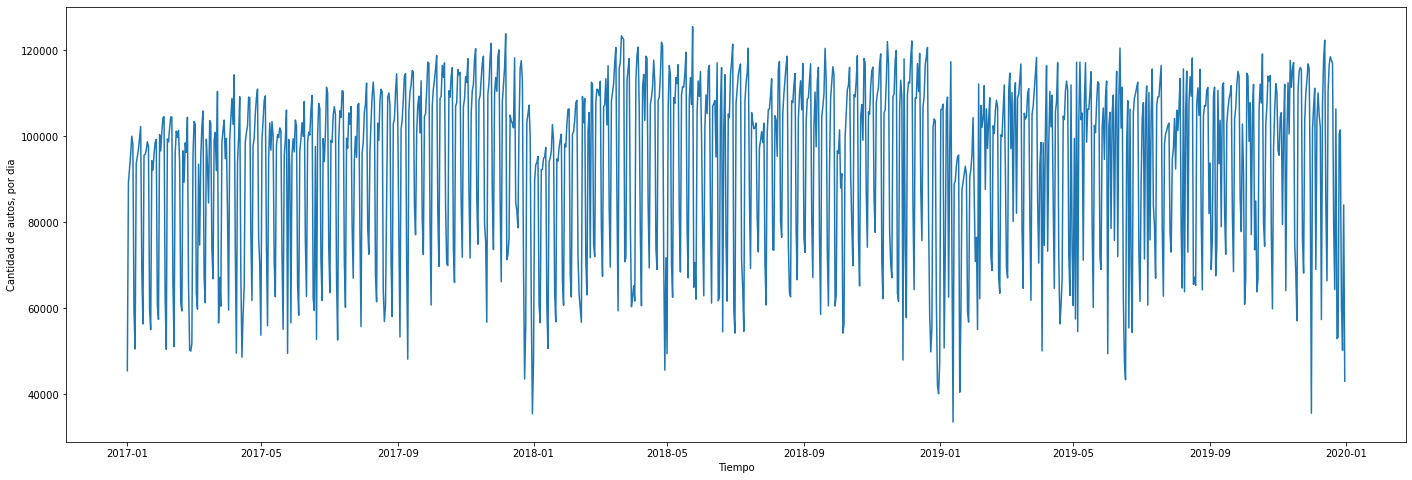

In [47]:
diario_ds_corregido = dsx.resample('D', on = 'fecha').sum()
diario_ds_corregido.drop(columns=['Year'], inplace = True)
print(diario_ds_corregido)
plt.figure(figsize = (24,8))
plt.plot(diario_ds_corregido.index, diario_ds_corregido.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

## 8. Media Movil
Usaremos el dataset "diario_ds_corregido", creado anteriormente, que contiene la cantidad de pasos por día corregido para crear un dataset que contenga la media movil con una ventana semanal del dataset. 


In [48]:
ventana = int(7)
dataset_promedio_tendencia = diario_ds_corregido.cantidad_pasos.rolling(window=ventana, center = True).mean()
dataset_promedio_tendencia

fecha
2017-01-01             NaN
2017-01-02             NaN
2017-01-03             NaN
2017-01-04    82947.714286
2017-01-05    83671.428571
                  ...     
2019-12-27    71924.857143
2019-12-28    70504.285714
2019-12-29             NaN
2019-12-30             NaN
2019-12-31             NaN
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: float64

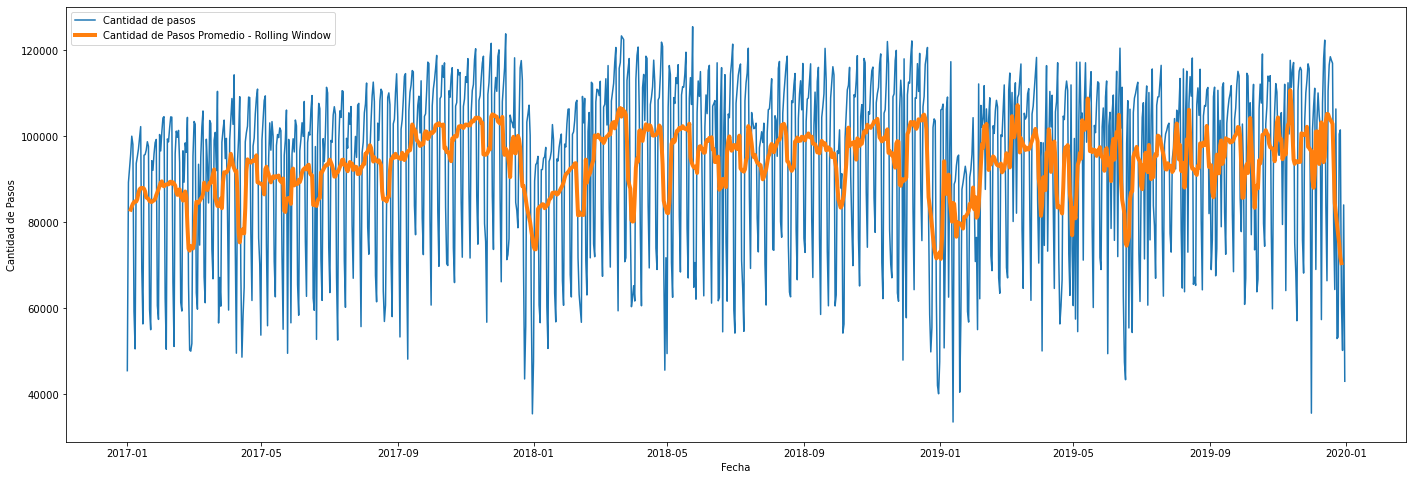

In [49]:
plt.figure(figsize = (24,8))
plt.plot(diario_ds_corregido.index, diario_ds_corregido.cantidad_pasos, label = 'Cantidad de pasos')
plt.plot(dataset_promedio_tendencia, lw = 4, label = 'Cantidad de Pasos Promedio - Rolling Window')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

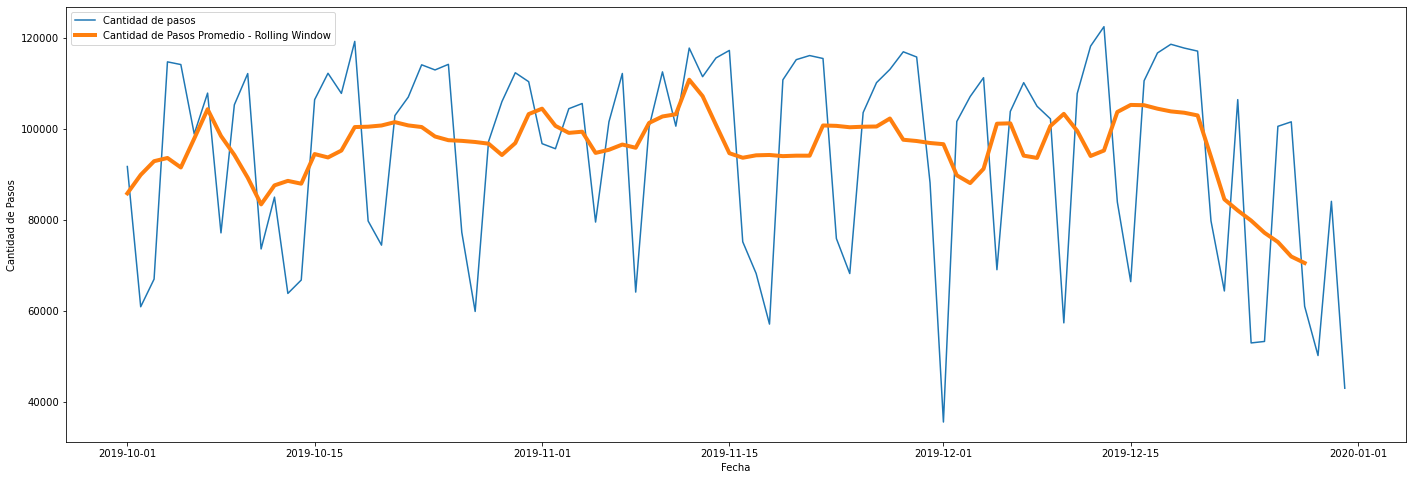

In [50]:
inicio_test = '2019-10-01'

diario_ds_corregido_w  =  diario_ds_corregido.loc[inicio_test:, :]
dataset_promedio_tendencia_w = pd.DataFrame(data=dataset_promedio_tendencia)
dataset_promedio_tendencia_w  = dataset_promedio_tendencia_w.loc[inicio_test:, :]

plt.figure(figsize = (24,8))
plt.plot(diario_ds_corregido_w.index, diario_ds_corregido_w.cantidad_pasos, label = 'Cantidad de pasos')
plt.plot(dataset_promedio_tendencia_w, lw = 4, label = 'Cantidad de Pasos Promedio - Rolling Window')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()


## 9. Autocorrelación

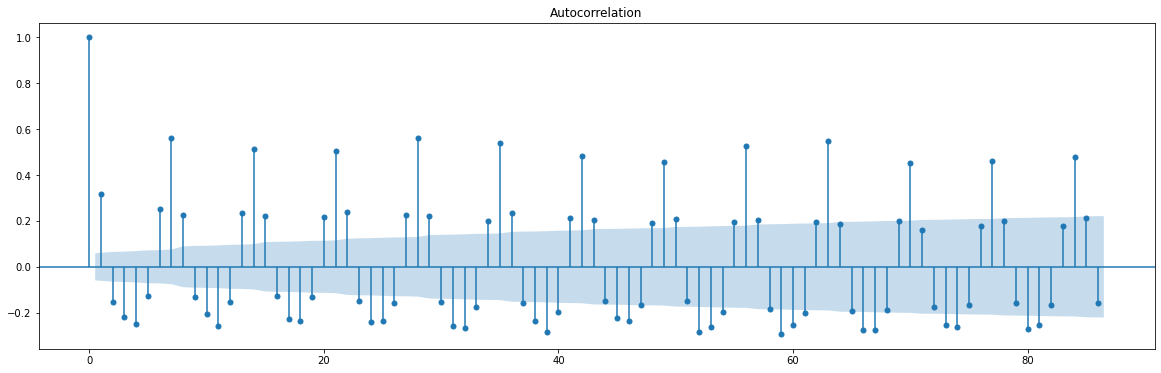

In [51]:
# Gráfico autocorrelación
fig, ax = plt.subplots(figsize=(20, 6))
plot_acf(diario_ds_corregido.cantidad_pasos, ax=ax, lags=86)
plt.show()

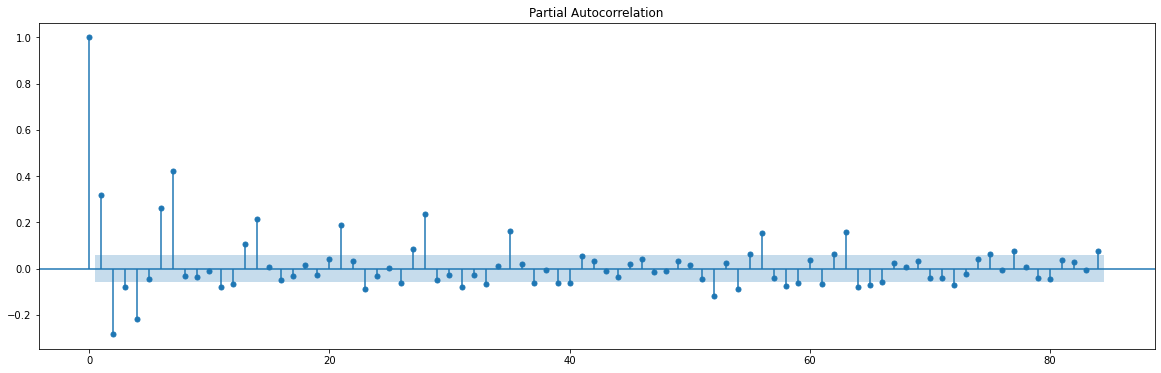

In [52]:
# Gráfico autocorrelación parcial
fig, ax = plt.subplots(figsize=(20, 6))
plot_pacf(diario_ds_corregido.cantidad_pasos, ax=ax, lags=84)
plt.show()

Los gráficos de autocorrelación y autocorrelación parcial muestran que existe una asociación en el tráfico vehicular para los mismos días de las semana respecto a semanas anteriores, o sea cada 7 días. Aun así no es del todo claro que un modelo autoregresivo, que serán ocupados en las secciones siguientes, puedan funcionar bien.


# 10. Dataset de entranimiento
Se realizará una predicción sobre la cantidad de tráfico diario para la Estación Illia utilizando el dataset diario_ds_corregido.<br/>
## 10.1 Modelo Benchmark
Para el modelo benchmark se creará y entrenará un Modelo autoregresivo recursivo "ForecasterAutoreg" a partir de un regresor RandomForestRegressor, con una ventana temporal de 8 semanas anteriores, equivalentes a 56 lags.  Esto último significa que, para cada predicción, se utilizan como predictores el tráfico vehicular de los 56 días anteriores.

Para conocer más sobre el uso de la librería skforecast, consultar la <a href="https://joaquinamatrodrigo.github.io/skforecast/guides/introduction-forecasting.html" target="_blank">guía de usuario.</a><br/>

Además se ocupará un regresor "Ridge" para coomparar resultados, sumando a la busqueda de hiperparametros para ambos regresores y modelos. 

In [53]:
# Verificar que el índice temporal está completo
(diario_ds_corregido.index == pd.date_range(start=diario_ds_corregido.index.min(),
                              end=diario_ds_corregido.index.max(),
                              freq=diario_ds_corregido.index.freq)).all()

True

In [54]:
#Se convierte en float32 todos los datos del Dataset, la fecha es un indice por lo que no se verá afectada.
diario_ds_corregido = diario_ds_corregido.astype('float32')
print(diario_ds_corregido.dtypes)
diario_ds_corregido

cantidad_pasos    float32
dtype: object


,cantidad_pasos
fecha,
2017-01-01,45478.0
2017-01-02,89289.0
2017-01-03,92602.0
2017-01-04,95813.0
2017-01-05,100044.0
...,...
2019-12-27,101501.0
2019-12-28,60999.0
2019-12-29,50185.0


In [54]:
diario_ds_corregido.to_csv('data_ts.csv')

Como conjunto de Test se utilizará el ultimo trimestre del año 2019 para evaluar la capacidad predictiva del modelo. <br/>
Para poder optimizar los hiperparámetros del modelo y evaluar su capacidad predictiva, se dividen los datos en 3 conjuntos, uno de entrenamiento, uno de validación y otro de test.

In [55]:
fin_train = '2019-06-30'
inicio_validacion = '2019-07-01'
fin_validacion = '2019-09-30'
inicio_test = '2019-10-01'

diario_ds_corregido_train = diario_ds_corregido.loc[:fin_train, :]
diario_ds_corregido_val   = diario_ds_corregido.loc[inicio_validacion:fin_validacion, :]
diario_ds_corregido_test  = diario_ds_corregido.loc[inicio_test:, :]

print(f"Fechas train      : {diario_ds_corregido_train.index.min()} --- {diario_ds_corregido_train.index.max()}")
print(f"Fechas validación : {diario_ds_corregido_val.index.min()} --- {diario_ds_corregido_val.index.max()}")
print(f"Fechas test       : {diario_ds_corregido_test.index.min()} --- {diario_ds_corregido_test.index.max()}")

Fechas train      : 2017-01-01 00:00:00 --- 2019-06-30 00:00:00
Fechas validación : 2019-07-01 00:00:00 --- 2019-09-30 00:00:00
Fechas test       : 2019-10-01 00:00:00 --- 2019-12-31 00:00:00


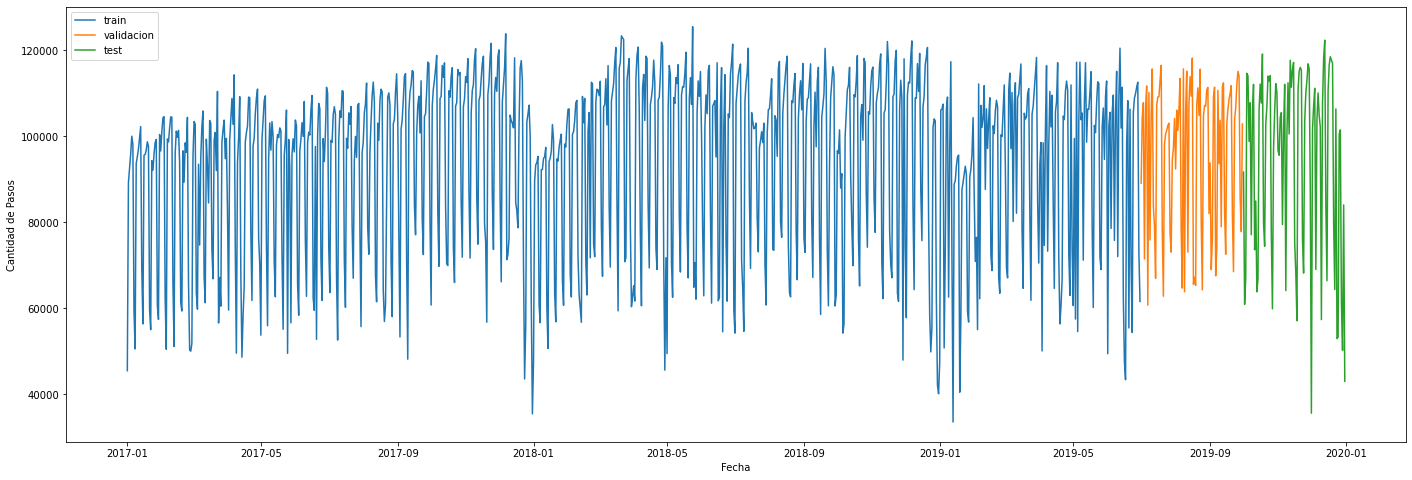

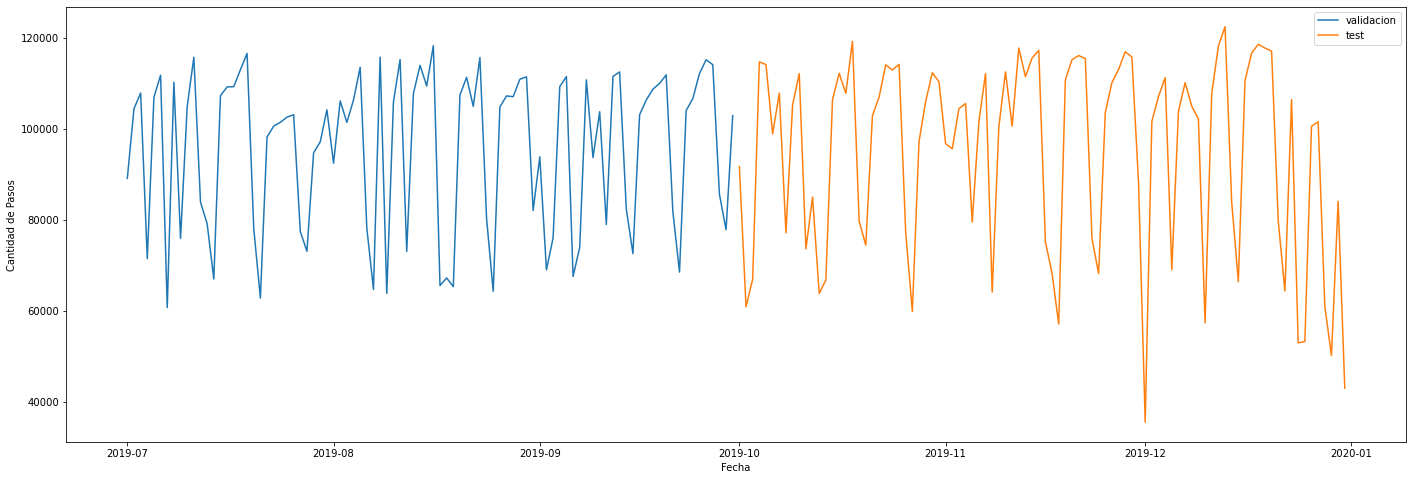

In [56]:
# Gráfico
plt.figure(figsize = (24,8))
plt.plot(diario_ds_corregido_train.index, diario_ds_corregido_train.cantidad_pasos, label = 'train')
plt.plot(diario_ds_corregido_val.index, diario_ds_corregido_val.cantidad_pasos, label = 'validacion')
plt.plot(diario_ds_corregido_test.index, diario_ds_corregido_test.cantidad_pasos, label = 'test')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

# Gráfico
plt.figure(figsize = (24,8))
plt.plot(diario_ds_corregido_val.index, diario_ds_corregido_val.cantidad_pasos, label = 'validacion')
plt.plot(diario_ds_corregido_test.index, diario_ds_corregido_test.cantidad_pasos, label = 'test')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

### 10.1.1 Entrenamiento Modelo Benchmark

In [57]:
# Creación y entrenamiento forecaster
forecaster_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=42),
                    lags=56
                )

forecaster_rf.fit(y=diario_ds_corregido_train['cantidad_pasos'])

forecaster_rf

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(random_state=42)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56]
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

### 10.1.2 Predicción (backtest) Modelo Benchmark
Para la predicción se utilizará un backtest que evalúa el comportamiento que habría tenido el modelo si se hubiese entrenado con los datos desde 2017-01-01 al 2019-09-30 y, después, se realizan predicciones de 7 en 7 días (steps). A este tipo de evaluación se le conoce como backtesting, y puede aplicarse fácilmente con la función backtesting_forecaster(). Esta función devuelve, además de las predicciones, una métrica de error.



In [58]:
# Backtest
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster_rf,
                            y          = diario_ds_corregido.cantidad_pasos,
                            initial_train_size = len(diario_ds_corregido.loc[:fin_validacion]),
                            steps      = 1,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Se añade el índice temporal a las predicciones
predicciones = pd.DataFrame(data=predicciones, index=diario_ds_corregido_test.index, columns=['cantidad_pasos'])
print(f'Error backtest: {metrica}')

Number of observations used for training: 1003
Number of observations used for testing: 92
    Number of folds: 92
    Number of steps per fold: 1
Error backtest: [13846.68956522]


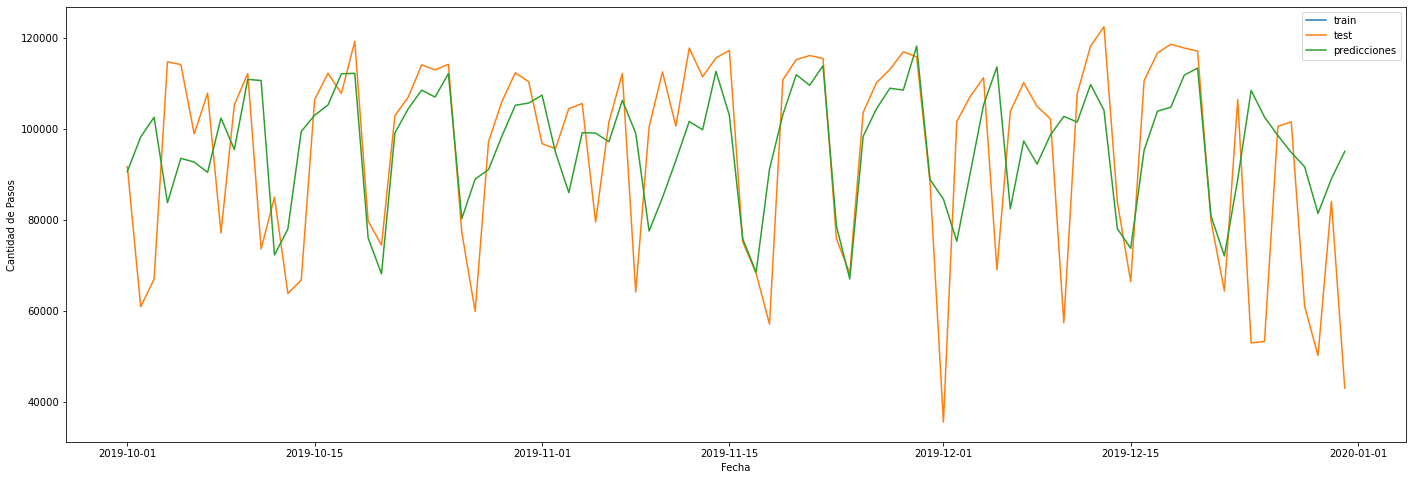

In [59]:
# Gráfico
plt.figure(figsize = (24,8))
plt.plot(diario_ds_corregido_train.loc[diario_ds_corregido_train.index.strftime('%Y-%m-%d')>='2019-08-01'].index, diario_ds_corregido_train.loc[diario_ds_corregido_train.index.strftime('%Y-%m-%d')>='2019-08-01'].cantidad_pasos, label = 'train')
plt.plot(diario_ds_corregido_test.index, diario_ds_corregido_test.cantidad_pasos, label = 'test')
plt.plot(predicciones.index, predicciones.cantidad_pasos, label = 'predicciones')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

### 10.1.3 Error modelo benchmark

In [60]:
#Calculamos la raíz del error cuadratico medio (rmse) para train y test
rmse_test_tree = np.sqrt(mean_squared_error(diario_ds_corregido_test, predicciones))

#Calculamos el error r2_score
r2_test_tree = r2_score(diario_ds_corregido_test, predicciones)

#Calculamos el MAE
mae_test_tree = mean_absolute_error(diario_ds_corregido_test, predicciones)

print(f'Raíz del error cuadrático medio en Test: {rmse_test_tree}')
print(f'R2 en Test: {r2_test_tree}')
print(f'MAE en Test: {mae_test_tree}')

modelos = pd.DataFrame()
modelos = modelos.assign(Modelo=None,R2=None,RMSE=None,MAE=None)
nueva_fila = { 'Modelo': 'Bechmark ForecasterAutoreg w/ Random Forest', 'R2': r2_test_tree, 'RMSE': rmse_test_tree, 'MAE': mae_test_tree} # creamos un diccionario
modelos = modelos.append(nueva_fila, ignore_index=True)
modelos

Raíz del error cuadrático medio en Test: 19418.277409565544
R2 en Test: 0.20759406764619004
MAE en Test: 13846.689565217393


,Modelo,R2,RMSE,MAE
0,Bechmark ForecasterAutoreg w/ Random Forest,0.207594,19418.27741,13846.689565


#### 10.1.4 Importancia predictores
Para el regresor RandomForestRegressor(), la importancia de los predictores se basa en la reducción de impureza y es accesible mediante el método get_feature_importances(). El orden devuelto se corresponde con el de los lags.

In [61]:
# Importancia predictores
impotancia = forecaster_rf.get_feature_importances()
dict(zip(forecaster_rf.lags, impotancia))

{1: 0.10593985903641158,
 2: 0.015002563306656605,
 3: 0.009180007868698773,
 4: 0.009853558805005274,
 5: 0.0094981048826069,
 6: 0.005875162625367797,
 7: 0.04514014801642117,
 8: 0.009108810545764795,
 9: 0.00621953410151232,
 10: 0.012115632889562586,
 11: 0.004788561592440287,
 12: 0.004194284703528542,
 13: 0.004788878438600388,
 14: 0.009447367628903629,
 15: 0.0030401767582692056,
 16: 0.007392190998541889,
 17: 0.00580514962273579,
 18: 0.0052216606376367354,
 19: 0.003828269990706756,
 20: 0.005093134107566798,
 21: 0.005867179867737831,
 22: 0.012337447319461438,
 23: 0.005995788103126989,
 24: 0.006793424366777304,
 25: 0.005412934391793048,
 26: 0.009814344457238926,
 27: 0.01002450883110182,
 28: 0.2127975528186359,
 29: 0.008731187229237033,
 30: 0.00586246599876872,
 31: 0.005155366787316245,
 32: 0.003346799204760836,
 33: 0.0038692483874779547,
 34: 0.004792112251643756,
 35: 0.06683305907635603,
 36: 0.0064768025490790325,
 37: 0.009014237945003613,
 38: 0.0053912750

## 10.2 Modelo 2: Benchmark con Regresor Ridge
Se crea y entrena un modelo autorregresivo recursivo (ForecasterAutoreg) a partir de un modelo de regresión lineal con penalización Ridge y una ventana temporal de 8 semanas (56 lags). Esto último significa que, para cada predicción, se utilizan como predictores el tráfico vehicular de los 56 días anteriores.

#### 10.2.1 Modelo 2: Entrenamiento

In [62]:
# Creación y entrenamiento forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor=Ridge(),
                    lags=56
                )

forecaster_rf.fit(y=diario_ds_corregido_train['cantidad_pasos'])

forecaster_rf

=======================ForecasterAutoreg=======================
Regressor: Ridge()
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56]
Exogenous variable: False, None
Parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

#### 10.2.2 Modelo 2: Predicción

In [63]:
# Backtest
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster_rf,
                            y          = diario_ds_corregido.cantidad_pasos,
                            initial_train_size = len(diario_ds_corregido.loc[:fin_validacion]),
                            steps      = 1,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Se añade el índice temporal a las predicciones
predicciones = pd.DataFrame(data=predicciones, index=diario_ds_corregido_test.index, columns=['cantidad_pasos'])
print(f'Error backtest: {metrica}')

Number of observations used for training: 1003
Number of observations used for testing: 92
    Number of folds: 92
    Number of steps per fold: 1
Error backtest: [15084.83338617]


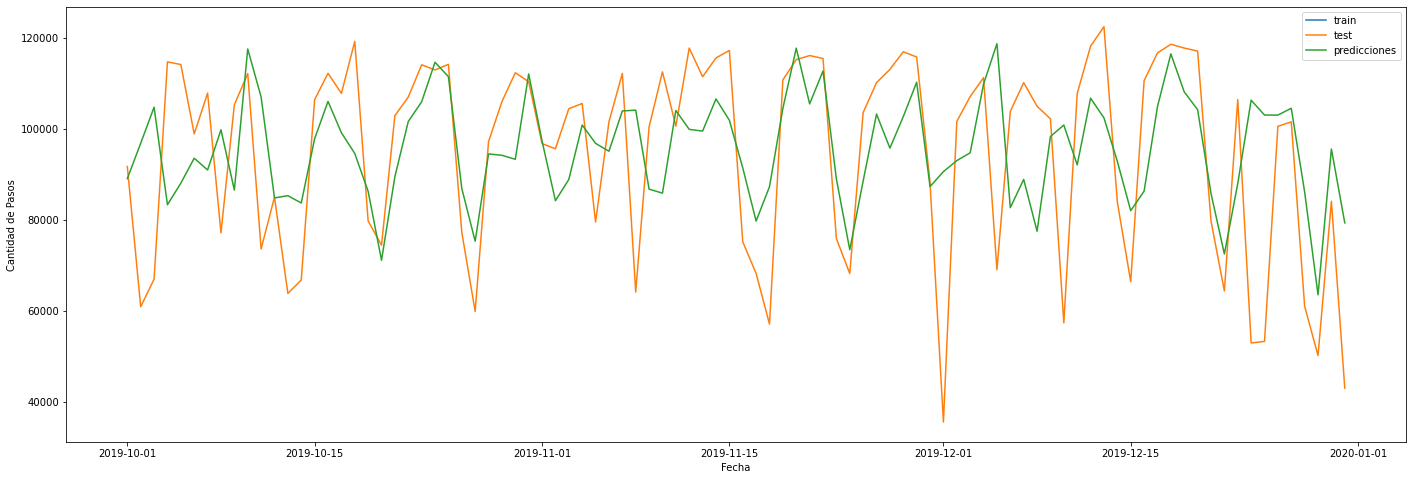

In [64]:
# Gráfico
plt.figure(figsize = (24,8))
plt.plot(diario_ds_corregido_train.loc[diario_ds_corregido_train.index.strftime('%Y-%m-%d')>='2019-08-01'].index, diario_ds_corregido_train.loc[diario_ds_corregido_train.index.strftime('%Y-%m-%d')>='2019-08-01'].cantidad_pasos, label = 'train')
plt.plot(diario_ds_corregido_test.index, diario_ds_corregido_test.cantidad_pasos, label = 'test')
plt.plot(predicciones.index, predicciones.cantidad_pasos, label = 'predicciones')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

#### 10.2.3 Modelo 2: Error

In [65]:
#Calculamos la raíz del error cuadratico medio (rmse) para train y test
rmse_test_tree = np.sqrt(mean_squared_error(diario_ds_corregido_test, predicciones))

#Calculamos el error r2_score
r2_test_tree = r2_score(diario_ds_corregido_test, predicciones)

#Calculamos el MAE
mae_test_tree = mean_absolute_error(diario_ds_corregido_test, predicciones)

print(f'Raíz del error cuadrático medio en Test: {rmse_test_tree}')
print(f'R2 en Test: {r2_test_tree}')
print(f'MAE en Test: {mae_test_tree}')

nueva_fila = { 'Modelo': 'Bechmark ForecasterAutoreg w/ Ridge', 'R2': r2_test_tree, 'RMSE': rmse_test_tree, 'MAE': mae_test_tree} # creamos un diccionario
modelos = modelos.append(nueva_fila, ignore_index=True)
modelos

Raíz del error cuadrático medio en Test: 19604.738626420967
R2 en Test: 0.1923030755972962
MAE en Test: 15084.833386172604


,Modelo,R2,RMSE,MAE
0,Bechmark ForecasterAutoreg w/ Random Forest,0.207594,19418.277410,13846.689565
1,Bechmark ForecasterAutoreg w/ Ridge,0.192303,19604.738626,15084.833386


#### 10.2.4 Importancia predictores
Cuando el regresor empleado es un Ridge(), la importancia queda reflejada en los coeficientes del modelo, que se obtienen con el método get_coef()

In [66]:
# Importancia predictores
impotancia = forecaster_rf.get_coef()
dict(zip(forecaster_rf.lags, impotancia))

{1: 0.20346098548930164,
 2: -0.03628475622324944,
 3: 0.0621485765205155,
 4: -0.026072092388186918,
 5: 0.06737295873376713,
 6: 0.03417919485796495,
 7: 0.15636987138265226,
 8: -0.028593716643081017,
 9: 0.012159454123487932,
 10: 0.03925669051006585,
 11: -0.050707492801689104,
 12: 0.0010473364046691045,
 13: 0.017688683758793854,
 14: 0.03845024152575654,
 15: -0.02418625028982848,
 16: 0.051077498889412924,
 17: 0.013891723714483785,
 18: 0.01625998499621463,
 19: 0.04316420298622786,
 20: -0.012181188842359832,
 21: 0.034694228959432846,
 22: 0.04207234437080824,
 23: -0.07609778585572306,
 24: 0.026880174333828475,
 25: 0.016802244936626808,
 26: -0.01736972444533966,
 27: 0.004986288286209904,
 28: 0.16324953456325775,
 29: -0.05277345951341008,
 30: 0.006970899400126799,
 31: -0.05252594126635619,
 32: -0.0026248559343297847,
 33: 0.010793263765504468,
 34: -0.047257470169117216,
 35: 0.11144055459520943,
 36: 0.003806707118699027,
 37: -0.055723336002824655,
 38: -0.008073

## 10.3 Modelo 3: Benchmark con regresor RandomForest y Ajustes de Hiperparametros
- La librería skforecast dispone de la estrategia de validación cruzada temporal y de backtesting.
- Es importante no incluir los datos de test en el proceso de búsqueda para no caer en problemas de overfitting

Con el objetivo de identificar la mejor combinación de lags e hiperparámetros, se recurre a un Grid Search con validación por backtesting. Este proceso consiste en entrenar un modelo con cada combinación de hiperparámetros y lags, y evaluar su capacidad predictiva mediante backtesting.
<br/><br/>
En el proceso de búsqueda es importante evaluar los modelos utilizando únicamente los datos de validación y no incluir los de test, estos se utilizan solo en último lugar para evaluar al modelo final.

In [68]:
# Grid search de hiperparámetros
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=42, n_jobs=-1),
                    lags      = 28 # Este valor será remplazado en el grid search
                 )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10,15,20]}

# Lags utilizados como predictores
lags_grid = [28, 56, 84]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = diario_ds_corregido.loc[:fin_validacion, 'cantidad_pasos'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 7,
                        method      = 'cv',
                        metric      = 'mean_absolute_error',
                        initial_train_size    = len(diario_ds_corregido_train),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                   )

2021-09-20 09:20:21,721 root       INFO  Number of models compared: 45
loop lags_grid: 100%|██████████| 3/3 [20:08<00:00, 402.87s/it]  
2021-09-20 09:40:30,344 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84] 
params: {'max_depth': 5, 'n_estimators': 500}



In [70]:
resultados_grid

,lags,params,metric,max_depth,n_estimators
35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.514947,5,500
34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.515497,5,100
30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 50}",0.524365,3,50
32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.524480,3,500
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.527181,3,100
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.527877,3,500
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.529511,3,100
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 50}",0.529723,10,50
33,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 50}",0.530241,5,50
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.531625,5,500


#### 10.3.1 Modelo 3: Entrenamiento con los mejores Hiperparametros 

In [67]:
# Crear y entrenar forecaster con mejores hiperparámetros
regressor = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=42,n_jobs=-1)

forecaster_rf = ForecasterAutoreg(
                    regressor = regressor,
                    lags      = 84
                )

forecaster_rf.fit(y=diario_ds_corregido_train.cantidad_pasos)

#### 10.3.2 Modelo 3: Predicción

In [68]:
# Backtest
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster_rf,
                            y          = diario_ds_corregido.cantidad_pasos,
                            initial_train_size = len(diario_ds_corregido.loc[:fin_validacion]),
                            steps      = 1,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Se añade el índice temporal a las predicciones
predicciones = pd.DataFrame(data=predicciones, index=diario_ds_corregido_test.index, columns=['cantidad_pasos'])
print(f'Error backtest: {metrica}')

Number of observations used for training: 1003
Number of observations used for testing: 92
    Number of folds: 92
    Number of steps per fold: 1
Error backtest: [12889.56229374]


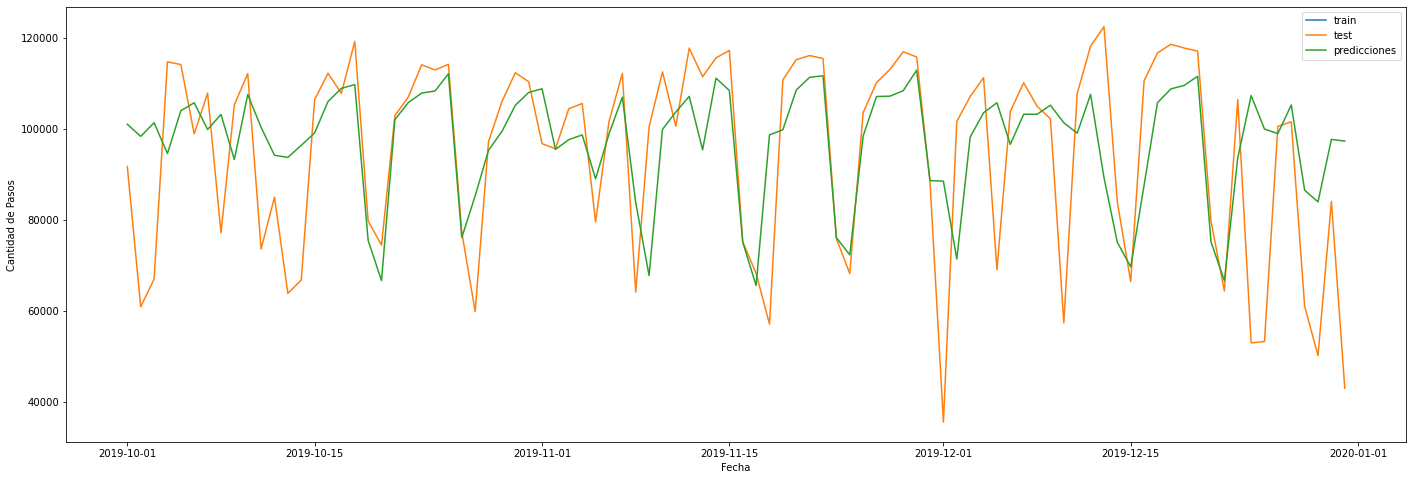

In [69]:
# Gráfico
plt.figure(figsize = (24,8))
plt.plot(diario_ds_corregido_train.loc[diario_ds_corregido_train.index.strftime('%Y-%m-%d')>='2019-08-01'].index, diario_ds_corregido_train.loc[diario_ds_corregido_train.index.strftime('%Y-%m-%d')>='2019-08-01'].cantidad_pasos, label = 'train')
plt.plot(diario_ds_corregido_test.index, diario_ds_corregido_test.cantidad_pasos, label = 'test')
plt.plot(predicciones.index, predicciones.cantidad_pasos, label = 'predicciones')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

#### 10.3.3 Modelo 3: Error

In [70]:
#Calculamos la raíz del error cuadratico medio (rmse) para train y test
rmse_test_tree = np.sqrt(mean_squared_error(diario_ds_corregido_test, predicciones))

#Calculamos el error r2_score
r2_test_tree = r2_score(diario_ds_corregido_test, predicciones)

#Calculamos el MAE
mae_test_tree = mean_absolute_error(diario_ds_corregido_test, predicciones)

print(f'Raíz del error cuadrático medio en Test: {rmse_test_tree}')
print(f'R2 en Test: {r2_test_tree}')
print(f'MAE en Test: {mae_test_tree}')

nueva_fila = { 'Modelo': 'Bechmark Optimizado ForecasterAutoreg w/ Random Forest', 'R2': r2_test_tree, 'RMSE': rmse_test_tree, 'MAE': mae_test_tree} # creamos un diccionario
modelos = modelos.append(nueva_fila, ignore_index=True)
modelos

Raíz del error cuadrático medio en Test: 18655.391091182206
R2 en Test: 0.2686335534640458
MAE en Test: 12889.56229373778


,Modelo,R2,RMSE,MAE
0,Bechmark ForecasterAutoreg w/ Random Forest,0.207594,19418.277410,13846.689565
1,Bechmark ForecasterAutoreg w/ Ridge,0.192303,19604.738626,15084.833386
2,Bechmark Optimizado ForecasterAutoreg w/ Rando...,0.268634,18655.391091,12889.562294


#### 10.3.4 Importancia predictores

In [71]:
# Importancia predictores
impotancia = forecaster_rf.get_feature_importances()
dict(zip(forecaster_rf.lags, impotancia))

{1: 0.11960708651979585,
 2: 0.00806125669917944,
 3: 0.002178010602893564,
 4: 0.00340501091903993,
 5: 0.004286681935305585,
 6: 0.0022606775067460128,
 7: 0.01622126205378077,
 8: 0.002601926140095608,
 9: 0.0024141604676820444,
 10: 0.005681168761842532,
 11: 0.0011900891761035517,
 12: 0.0016581997223066884,
 13: 0.0012463125967669818,
 14: 0.004101625126585118,
 15: 0.0016025773687372666,
 16: 0.002457915595521031,
 17: 0.002386370125910162,
 18: 0.0028091097600052442,
 19: 0.0005479739944784178,
 20: 0.0011538472377955584,
 21: 0.0027527915162129093,
 22: 0.003949187392326421,
 23: 0.0015729035030677537,
 24: 0.0034682932106138613,
 25: 0.0023756709235522536,
 26: 0.0031195210762961583,
 27: 0.005855941639165382,
 28: 0.15945243831442588,
 29: 0.0022964253796068724,
 30: 0.0011300815113281773,
 31: 0.0011051445221953362,
 32: 0.0008441272843493127,
 33: 0.0011331815927268622,
 34: 0.0011586801503114437,
 35: 0.014632535431014856,
 36: 0.003489802620088862,
 37: 0.004661541876597

## 10.4. Modelo 4: Benchmark con regresor Ridge y Ajustes de Hiperparametros


In [71]:
# Grid search de hiperparámetros
forecaster_rf = ForecasterAutoreg(
                    regressor = Ridge(normalize=True),
                    lags      = 28 # Este valor será remplazado en el grid search
                 )

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 3, 10)}

# Lags utilizados como predictores
lags_grid = [28, 56, 84]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = diario_ds_corregido.loc[:fin_validacion, 'cantidad_pasos'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 1,
                        method      = 'cv',
                        metric      = 'mean_absolute_error',
                        initial_train_size    = len(diario_ds_corregido_train),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                   )

2021-09-29 23:28:48,974 root       INFO  Number of models compared: 30
loop lags_grid: 100%|██████████| 3/3 [00:30<00:00, 10.19s/it]   
2021-09-29 23:29:19,555 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84] 
params: {'alpha': 0.46415888336127775}



In [72]:
resultados_grid

,lags,params,metric,alpha
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.46415888336127775},12459.323191,0.464159
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 2.154434690031882},12653.480015,2.154435
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},13059.733950,0.100000
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},13145.224932,0.100000
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.46415888336127775},13146.753072,0.464159
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.46415888336127775},13151.686661,0.464159
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.021544346900318832},13198.715724,0.021544
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.004641588833612777},13213.809239,0.004642
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.001},13217.170532,0.001000
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 2.154434690031882},13315.069544,2.154435


#### 10.4.1 Modelo 4: Entrenamiento con los mejores Hiperparametros 

In [72]:
# Crear y entrenar forecaster con mejores hiperparámetros
regressor = Ridge(alpha=0.46415888336127775,normalize=True)

forecaster_rf = ForecasterAutoreg(
                    regressor = regressor,
                    lags      = 84
                )

forecaster_rf.fit(y=diario_ds_corregido_train.cantidad_pasos)

#### 10.4.2 Modelo 4: Predicción

In [73]:
# Backtest
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster_rf,
                            y          = diario_ds_corregido.cantidad_pasos,
                            initial_train_size = len(diario_ds_corregido.loc[:fin_validacion]),
                            steps      = 1,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Se añade el índice temporal a las predicciones
predicciones = pd.DataFrame(data=predicciones, index=diario_ds_corregido_test.index, columns=['cantidad_pasos'])
print(f'Error backtest: {metrica}')

Number of observations used for training: 1003
Number of observations used for testing: 92
    Number of folds: 92
    Number of steps per fold: 1
Error backtest: [14944.46210495]


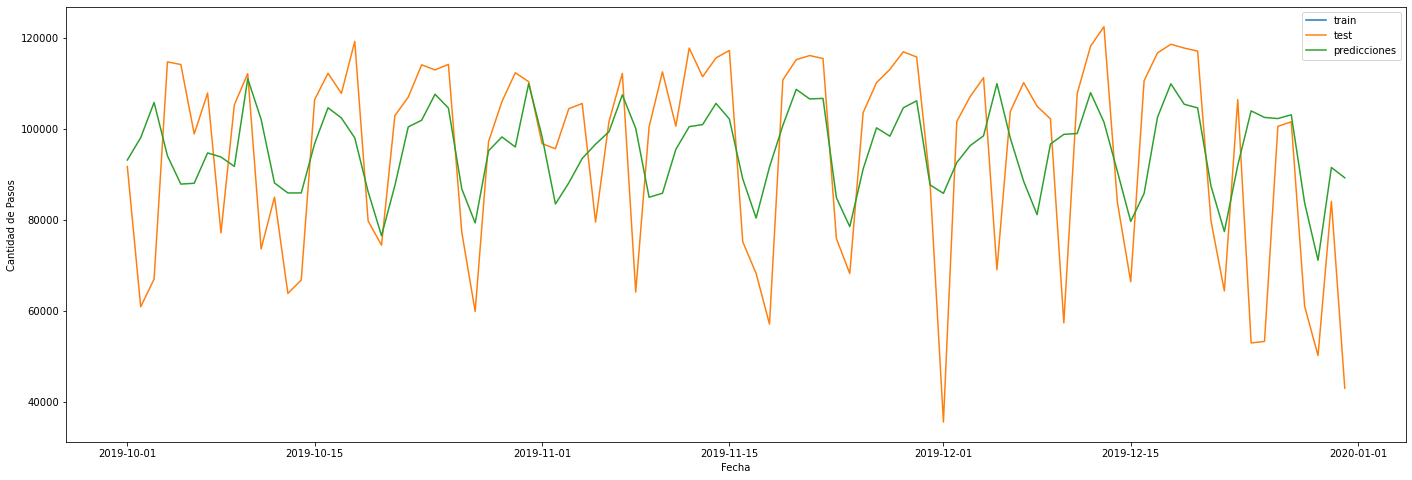

In [74]:
# Gráfico
plt.figure(figsize = (24,8))
plt.plot(diario_ds_corregido_train.loc[diario_ds_corregido_train.index.strftime('%Y-%m-%d')>='2019-08-01'].index, diario_ds_corregido_train.loc[diario_ds_corregido_train.index.strftime('%Y-%m-%d')>='2019-08-01'].cantidad_pasos, label = 'train')
plt.plot(diario_ds_corregido_test.index, diario_ds_corregido_test.cantidad_pasos, label = 'test')
plt.plot(predicciones.index, predicciones.cantidad_pasos, label = 'predicciones')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

#### 10.4.3 Modelo 4: Error

In [75]:
#Calculamos la raíz del error cuadratico medio (rmse) para train y test
rmse_test_tree = np.sqrt(mean_squared_error(diario_ds_corregido_test, predicciones))

#Calculamos el error r2_score
r2_test_tree = r2_score(diario_ds_corregido_test, predicciones)

#Calculamos el MAE
mae_test_tree = mean_absolute_error(diario_ds_corregido_test, predicciones)

print(f'Raíz del error cuadrático medio en Test: {rmse_test_tree}')
print(f'R2 en Test: {r2_test_tree}')
print(f'MAE en Test: {mae_test_tree}')

nueva_fila = { 'Modelo': 'Bechmark Optimizado ForecasterAutoreg w/ Ridge', 'R2': r2_test_tree, 'RMSE': rmse_test_tree, 'MAE': mae_test_tree} # creamos un diccionario
modelos = modelos.append(nueva_fila, ignore_index=True)
modelos

Raíz del error cuadrático medio en Test: 18957.454700104263
R2 en Test: 0.24475758941728032
MAE en Test: 14944.462104948336


,Modelo,R2,RMSE,MAE
0,Bechmark ForecasterAutoreg w/ Random Forest,0.207594,19418.277410,13846.689565
1,Bechmark ForecasterAutoreg w/ Ridge,0.192303,19604.738626,15084.833386
2,Bechmark Optimizado ForecasterAutoreg w/ Rando...,0.268634,18655.391091,12889.562294
3,Bechmark Optimizado ForecasterAutoreg w/ Ridge,0.244758,18957.454700,14944.462105


#### 10.4.4 Importancia predictores

In [76]:
# Importancia predictores
impotancia = forecaster_rf.get_coef()
dict(zip(forecaster_rf.lags, impotancia))

{1: 0.09339805655106505,
 2: -0.006072492641567618,
 3: 0.03549428517430576,
 4: -0.006602987790940796,
 5: 0.025294056917587973,
 6: 0.02786277737625225,
 7: 0.07681749974772335,
 8: 0.004818204900663544,
 9: 0.004296194578909953,
 10: 0.027819119943918693,
 11: -0.014135475179593794,
 12: -0.0035602025635416857,
 13: 0.01648223982028819,
 14: 0.03455276764337345,
 15: -0.002702186092308654,
 16: 0.019954238263504866,
 17: 0.012218033545372502,
 18: 0.010666127317987852,
 19: 0.0168147346006433,
 20: 0.00298478098993874,
 21: 0.028922013661864147,
 22: 0.020701454420935538,
 23: -0.020955912166735837,
 24: 0.00032921958712871496,
 25: 0.011950867429697662,
 26: -0.011956235004243702,
 27: 0.004600809447687298,
 28: 0.09020399310358951,
 29: 0.0019293389694419929,
 30: -0.005353239250528956,
 31: -0.017390026805526235,
 32: -0.007088151600894913,
 33: -0.007361797435946626,
 34: -0.018991803960489398,
 35: 0.06716232974776505,
 36: 0.011638195422719329,
 37: -0.026529581787629684,
 38:

### 10.5 Conclusiones Modelos (Primera parte)

- El mejor modelo es el modelo Optimizado de ForecasterAutoreg con el regresor RandomForest con un MAE de 12889.56. 
- Las metricas de error son altas aun, esto puede deberse a la falta de variables exógenas como el día de la semana o si el día es feriado o no. En la siguiente sección se realizará la incorporación de variables exógenas.
- Para la importancia de los predictores se tomará en cuenta solo el regresor RandomForest optimizado. En este modelo la importancia de los predictores muestran que los lags 1, 28, 56 y 63 son las más altas, para el mismo regresor no optimizado se tiene que los lag con mayor importancia son el lag 1, 28 y 56. En resumen para el modelo Optimizado de ForecasterAutoreg con el regresor RandomForest se tiene que: 
    - Lag 1 representa el 12% del valor total de la predicción, correspondiente al valor del día anterior del valor a predecir.
    - Lag 28 representa el 15% del valor total de la predicción, correspondiente al valor de la semana cuarta anterior del valor a predecir.
    - Lag 56 representa el 12.3% del valor total de la predicción, correspondiente al valor de la semana octava anterior del valor a predecir.
    - Lag 63 representa el 34% del valor total de la predicción, correspondiente al valor de la semana novena anterior del valor a predecir.

# 11. Forecasting autorregresivo recursivo con variables exógenas

Para evitar errores, se debe descargar el dataset de <a href="https://soovs-my.sharepoint.com/:x:/g/personal/10434_officehome_info/EeMpjlcAajxIkzEpVa29ASgBLBONpAV1D05NaiwH_0De2A?e=hWhfU8" target="_blank">Feriados en el siguiente  - LINK.</a>. Este dataset se generó en base a la información historica de los días festivos de Argentina en google.<br/>
Durante está etapa se trabajará solo con el Modelo Benchmark con el Regresor RandomForest


In [77]:
url = 'https://raw.githubusercontent.com/wpinedailabaca/acamica/main/feriados.csv'
feriados = pd.read_csv(url, sep=',')

## 11.1 Incorporación de variables exógenas
Tomando en cuenta que los datos tienen una estacionalidad semanal y anual, se crearan tres funciones: <br/><br/>
a) Función "dow" que añadirá los features:
- dow, número del día de la semana
- laboral, si el día es laboral o no
- feriado, Si es feriados normal en Argentina
- feriado_e, si es feriado especial en Argentina

<br/>
B) Función "dataframe_diario_crear", para esta función es necesario realizar el llamado primero de la función "dow" para evitar errores. El usuario debe ingresar el Dataframe y el número de semanas anteriores que quiere añadir como columnas. La función le devolverá un Dataframe con los valores del Dataframe original más los datos de X semanas anteriores puestos como columnas, con un corte en el valor inicial del Dataframe del día correspondiente a x semanas siguientes al valor inicial del Dataframe original.<br/> Ejemplo.- Dataframe original inicio: 2017-01-01, Dataframe de retorno inicio: 2017-02-26 para el valor de 8 semanas.<br/><br/>
C) Función "lastyear", para esta función es necesario realizar el llamado primero de la función "dataframe_diario_crear" para evitar errores. EL usuario deberá ingresar el Dataframe y el múmero de años anteiores que quiere añadir como columnas. La función devolverá un Dataframe con los Valores del Dataframe original más los datos de X años anteriores para el mismo día como columnas, , con un corte en el valor inicial del Dataframe del día correspondiente a x años siguientes al valor inicial del Dataframe original.<br/> Ejemplo.- Dataframe original inicio: 2017-01-01, Dataframe retornado inicio: 2018-01-01 para el valor de 1 año. 


In [78]:
def dow(dsx,feriados,cp="fecha"):
    #Convertimos en Dataframe
    ds = pd.DataFrame(data=dsx)
    #Fecha maximo del dataset, para saber donde cortar     
    fechamaxima_1 = max(ds.index.strftime('%Y-%m-%d')) 
    #Cargamos el datoset feriados
        #feriados = pd.read_csv('Datasets/feriados.csv', sep =',')
    #Convertimos en datetime el features fecha.
    feriados['fecha'] = pd.to_datetime(feriados['fecha'])
    #Convertimos el dataset feriados en un subdataset utilizando la fechamaximo del dataset ingresado a la función
    feriados=feriados.loc[feriados.fecha<fechamaxima_1]    
    #Tenemos dos casos: 
    #Indice tiene nombre fecha o no tiene nombre, esto debido al trabajo previo realizado con los dataset de entrada.
    if(ds.index.name==None): 
        #dow    
        ds['dow'] = ds.fecha.dt.dayofweek
        ds['dow_lun'] = [(1*1.0) if s == 0 else (0*1.0) for s in ds.dow]
        ds['dow_mar'] = [(1*1.0) if s == 1 else (0*1.0) for s in ds.dow]
        ds['dow_mie'] = [(1*1.0) if s == 2 else (0*1.0) for s in ds.dow]
        ds['dow_jue'] = [(1*1.0) if s == 3 else (0*1.0) for s in ds.dow]
        ds['dow_vie'] = [(1*1.0) if s == 4 else (0*1.0) for s in ds.dow]
        ds['dow_sab'] = [(1*1.0) if s == 5 else (0*1.0) for s in ds.dow]
        ds['dow_dom'] = [(1*1.0) if s == 6 else (0*1.0) for s in ds.dow]
        
        ds['month'] = ds.fecha.dt.month
        ds['month_ene'] = [(1*1.0) if s == 1 else (0*1.0) for s in ds.month]
        ds['month_feb'] = [(1*1.0) if s == 2 else (0*1.0) for s in ds.month]
        ds['month_mar'] = [(1*1.0) if s == 3 else (0*1.0) for s in ds.month]
        ds['month_abr'] = [(1*1.0) if s == 4 else (0*1.0) for s in ds.month]
        ds['month_may'] = [(1*1.0) if s == 5 else (0*1.0) for s in ds.month]
        ds['month_jun'] = [(1*1.0) if s == 6 else (0*1.0) for s in ds.month]
        ds['month_jul'] = [(1*1.0) if s == 7 else (0*1.0) for s in ds.month]
        ds['month_ago'] = [(1*1.0) if s == 8 else (0*1.0) for s in ds.month]
        ds['month_sep'] = [(1*1.0) if s == 9 else (0*1.0) for s in ds.month]
        ds['month_oct'] = [(1*1.0) if s == 10 else (0*1.0) for s in ds.month]
        ds['month_nov'] = [(1*1.0) if s == 11 else (0*1.0) for s in ds.month]
        ds['month_dic'] = [(1*1.0) if s == 12 else (0*1.0) for s in ds.month]        
        #Laboral o no
        ds['laboral'] = [(0*1.0) if s > 4 else (1*1.0) for s in ds.dow] 
        #Valores por defecto para feriados y feriados_e
        ds['feriado'] = [(1*1.0) if s > 4 else (0*1.0) for s in ds.dow]      
        ds['feriado_e'] = 0*1.0 
        #recorremos los valores del dataset feriados y cambiamos el valor de dataset de entrada donde el valor de la fecha del feriado concuerde.
        for x in feriados.values:
            if(x[1]==0):
                ds.at[x[0],'feriado']=1*1.0
                ds.at[x[0],'laboral']=0*1.0
            elif(x[1]==2):
                ds.at[x[0],'feriado_e']=1*1.0
                
        ds.drop(columns=['month'], inplace = True)
        ds.drop(columns=['dow'], inplace = True)
        ds = ds[["cantidad_pasos", 
                 "fecha",
                 'month_ene',
                 'month_feb',
                 'month_mar',
                 'month_abr',
                 'month_may',
                 'month_jun',
                 'month_jul',
                 'month_ago',
                 'month_sep',
                 'month_oct',
                 'month_nov',
                 'month_dic',
                 "dow_lun",
                 'dow_mar',
                 'dow_mie',
                 'dow_jue',
                 'dow_vie',
                 'dow_sab',
                 'dow_dom',
                 "laboral",
                 "feriado",
                 "feriado_e"]]
        return ds
    elif(ds.index.name==cp):
        #dow
        ds['fecha']  = pd.to_datetime(ds.index)
        ds['dow'] = ds.fecha.dt.dayofweek
        ds['dow_lun'] = [(1*1.0) if s == 0 else (0*1.0) for s in ds.dow]
        ds['dow_mar'] = [(1*1.0) if s == 1 else (0*1.0) for s in ds.dow]
        ds['dow_mie'] = [(1*1.0) if s == 2 else (0*1.0) for s in ds.dow]
        ds['dow_jue'] = [(1*1.0) if s == 3 else (0*1.0) for s in ds.dow]
        ds['dow_vie'] = [(1*1.0) if s == 4 else (0*1.0) for s in ds.dow]
        ds['dow_sab'] = [(1*1.0) if s == 5 else (0*1.0) for s in ds.dow]
        ds['dow_dom'] = [(1*1.0) if s == 6 else (0*1.0) for s in ds.dow]
        
        ds['month'] = ds.fecha.dt.month
        ds['month_ene'] = [(1*1.0) if s == 1 else (0*1.0) for s in ds.month]
        ds['month_feb'] = [(1*1.0) if s == 2 else (0*1.0) for s in ds.month]
        ds['month_mar'] = [(1*1.0) if s == 3 else (0*1.0) for s in ds.month]
        ds['month_abr'] = [(1*1.0) if s == 4 else (0*1.0) for s in ds.month]
        ds['month_may'] = [(1*1.0) if s == 5 else (0*1.0) for s in ds.month]
        ds['month_jun'] = [(1*1.0) if s == 6 else (0*1.0) for s in ds.month]
        ds['month_jul'] = [(1*1.0) if s == 7 else (0*1.0) for s in ds.month]
        ds['month_ago'] = [(1*1.0) if s == 8 else (0*1.0) for s in ds.month]
        ds['month_sep'] = [(1*1.0) if s == 9 else (0*1.0) for s in ds.month]
        ds['month_oct'] = [(1*1.0) if s == 10 else (0*1.0) for s in ds.month]
        ds['month_nov'] = [(1*1.0) if s == 11 else (0*1.0) for s in ds.month]
        ds['month_dic'] = [(1*1.0) if s == 12 else (0*1.0) for s in ds.month] 
        
        #laboral
        ds['laboral'] = [(0*1.0) if s > 4 else (1*1.0) for s in ds.dow]
        #Valores por defecto para feriados y feriados_e
        ds['feriado'] = [(1*1.0) if s > 4 else (0*1.0) for s in ds.dow]      
        ds['feriado_e'] = 0*1.0 
        #recorremos los valores del dataset feriados y cambiamos el valor de dataset de entrada donde el valor de la fecha del feriado concuerde.
        for x in feriados.values:
            if(x[1]==0):
                ds.at[x[0],'feriado']=1*1.0
                ds.at[x[0],'laboral']=0*1.0
            elif(x[1]==2):
                ds.at[x[0],'feriado_e']=1*1.0 
        ds.drop(columns=['month'], inplace = True)
        ds.drop(columns=['dow'], inplace = True)
        ds = ds[["cantidad_pasos", 
                 "fecha",
                 'month_ene',
                 'month_feb',
                 'month_mar',
                 'month_abr',
                 'month_may',
                 'month_jun',
                 'month_jul',
                 'month_ago',
                 'month_sep',
                 'month_oct',
                 'month_nov',
                 'month_dic',
                 "dow_lun",
                 'dow_mar',
                 'dow_mie',
                 'dow_jue',
                 'dow_vie',
                 'dow_sab',
                 'dow_dom',
                 "laboral",
                 "feriado",
                 "feriado_e"]]
        return ds        
    else:        
        return ds



In [79]:
#UItilizamos la función creada "dow" y como entrada utilizaremos el dataset diario_ds_corregido
diario_ds_corregido_f = dow(diario_ds_corregido,feriados,"fecha")
print('Dataset de salida para: diario_ds_corregido_f','\n')
diario_ds_corregido_f

Dataset de salida para: diario_ds_corregido_f 



,cantidad_pasos,fecha,month_ene,month_feb,month_mar,month_abr,month_may,month_jun,month_jul,month_ago,...,dow_lun,dow_mar,dow_mie,dow_jue,dow_vie,dow_sab,dow_dom,laboral,feriado,feriado_e
fecha,,,,,,,,,,,,,,,,,,,,,
2017-01-01,45478.0,2017-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2017-01-02,89289.0,2017-01-02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-01-03,92602.0,2017-01-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-01-04,95813.0,2017-01-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-01-05,100044.0,2017-01-05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,101501.0,2019-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2019-12-28,60999.0,2019-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2019-12-29,50185.0,2019-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [80]:
def dataframe_diario_crear(ds,semanas):
    #Fecha minimo del dataset de entrada
    fechaminima = min(ds.index.strftime('%Y-%m-%d'))
    #Utilizando la fecha minima del dataset de entrada se calculará la fecha donde comenzará el dataset de salida
    #teniendo en cuenta que el valor anterior maximo es la fecha de inicio de nuestro dataset de entrada.
    dias_adelante = 7*semanas #8 semanas
    fecha_adelante = pd.to_datetime(fechaminima) + pd.DateOffset(days=dias_adelante)
    fecha_adelante = fecha_adelante.strftime('%Y-%m-%d')    
    ds_aux =ds.loc[ds.index.strftime('%Y-%m-%d')>=fecha_adelante]
    #Se obtiene el dataset ds_aux, siendo un sub-dataset del dataset de entrada
    #Se obtiene la fecha minimo y maxima del dataset da_aux
    fechaminima = min(ds_aux.fecha.dt.strftime('%Y-%m-%d')) #26-02-2017
    fechamaxima = max(ds_aux.fecha.dt.strftime('%Y-%m-%d')) #31-12-2019
    #Se les dá nombre a las columnas y luego se reinicia los indices.
    ds_aux.columns = ['cantidad_pasos', 
                      'fecha',
                      'month_ene',
                      'month_feb',
                      'month_mar',
                      'month_abr',
                      'month_may',
                      'month_jun',
                      'month_jul',
                      'month_ago',
                      'month_sep',
                      'month_oct',
                      'month_nov',
                      'month_dic',
                      'dow_lun',
                      'dow_mar',
                      'dow_mie',
                      'dow_jue',
                      'dow_vie',
                      'dow_sab',
                      'dow_dom',
                      'laboral',
                      'feriado',
                      'feriado_e']
    ds_aux.reset_index(drop=True, inplace = True)
    #Loop de creación del dataset de salida con valores de las semanas anteriores concatenados horizontalmente
    for x in range(semanas):
        dias_atras = (x+1)*(-7)
        fecha_atras1 = pd.to_datetime(fechaminima) + pd.DateOffset(days=dias_atras)
        fecha_atras1 = fecha_atras1.strftime('%Y-%m-%d')
        fecha_atras2 = pd.to_datetime(fechamaxima) + pd.DateOffset(days=dias_atras)
        fecha_atras2 = fecha_atras2.strftime('%Y-%m-%d')
        dsX =ds.loc[np.logical_and(ds.index.strftime('%Y-%m-%d')>=fecha_atras1,ds.index.strftime('%Y-%m-%d')<=fecha_atras2)]
        dsX.columns = ['cantidad_pasos_s'+str(x+1), 
                       'fecha_ds', 
                       'month_ene_s'+str(x+1),
                       'month_feb_s'+str(x+1),
                       'month_mar_s'+str(x+1),
                       'month_abr_s'+str(x+1),
                       'month_may_s'+str(x+1),
                       'month_jun_s'+str(x+1),
                       'month_jul_s'+str(x+1),
                       'month_ago_s'+str(x+1),
                       'month_sep_s'+str(x+1),
                       'month_oct_s'+str(x+1),
                       'month_nov_s'+str(x+1),
                       'month_dic_s'+str(x+1),                       
                       'dow_lun_s'+str(x+1), 
                       'dow_mar_s'+str(x+1),
                       'dow_mie_s'+str(x+1),
                       'dow_jue_s'+str(x+1),
                       'dow_vie_s'+str(x+1),
                       'dow_sab_s'+str(x+1),
                       'dow_dom_s'+str(x+1),
                       'laboral_s'+str(x+1), 
                       'feriado_s'+str(x+1), 
                       'feriado_e_s'+str(x+1)]
        dsX.reset_index(drop=True, inplace = True)
        dsX2 = dsX.drop(columns = ['fecha_ds'])
        ds_aux = pd.concat([ds_aux, dsX2], axis=1)
    return ds_aux

In [81]:
#UItilizamos la función creada "dow" y como entrada utilizaremos el dataset diario_ds_corregido
#Se utilizará 12 semanas anteriores debido al número de lags utilizados en el mejor modelo de la sección 10.
diario_ds_corregido_f = dataframe_diario_crear(diario_ds_corregido_f,12)
print('Dataset de salida para: diario_ds_corregido_ff','\n')
diario_ds_corregido_f

Dataset de salida para: diario_ds_corregido_ff 



,cantidad_pasos,fecha,month_ene,month_feb,month_mar,month_abr,month_may,month_jun,month_jul,month_ago,...,dow_lun_s12,dow_mar_s12,dow_mie_s12,dow_jue_s12,dow_vie_s12,dow_sab_s12,dow_dom_s12,laboral_s12,feriado_s12,feriado_e_s12
0,60491.0,2017-03-26,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,98643.0,2017-03-27,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,101504.0,2017-03-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,103783.0,2017-03-29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,94821.0,2017-03-30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,101501.0,2019-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1007,60999.0,2019-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1008,50185.0,2019-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1009,84043.0,2019-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [82]:
def lastyear(dsx,anual):
    #Año minimo y maximo.
    yearmin = int(min(dsx.fecha.dt.strftime('%Y'))) #2017
    yearmax = int(max(dsx.fecha.dt.strftime('%Y'))) #2019
    #Se crea dataset vacio, con nombres de columnas.
    ds_aux = pd.DataFrame(columns=['cantidad_pasos_aa', 
                                   'fecha', 
                                   'month_ene_aa',
                                   'month_feb_aa',
                                   'month_mar_aa',
                                   'month_abr_aa',
                                   'month_may_aa',
                                   'month_jun_aa',
                                   'month_jul_aa',
                                   'month_ago_aa',
                                   'month_sep_aa',
                                   'month_oct_aa',
                                   'month_nov_aa',
                                   'month_dic_aa',
                                   'dow_lun_aa',
                                   'dow_mar_aa',
                                   'dow_mie_aa',
                                   'dow_jue_aa',
                                   'dow_vie_aa',
                                   'dow_sab_aa',
                                   'dow_dom_aa', 
                                   'laboral_aa',
                                   'feriado_aa',
                                   'feriado_e_aa'])
    #Loop de años 
    for x in range(int(yearmin+1),int(yearmax+1)):
        ds = dsx.copy()
        ds = ds[["cantidad_pasos", 
                 "fecha",
                 'month_ene',
                 'month_feb',
                 'month_mar',
                 'month_abr',
                 'month_may',
                 'month_jun',
                 'month_jul',
                 'month_ago',
                 'month_sep',
                 'month_oct',
                 'month_nov',
                 'month_dic',
                 "dow_lun",
                 'dow_mar',
                 'dow_mie',
                 'dow_jue',
                 'dow_vie',
                 'dow_sab',
                 'dow_dom',
                 "laboral",
                 "feriado",
                 "feriado_e"]]
        #sub-dataset que contiene la información del año anterior
        ds_aux_a=ds.loc[ds.fecha.dt.strftime('%Y')==str(x-1)]  #2017,2018,               
        ds_aux_a.columns = ['cantidad_pasos_aa', 
                            'fecha', 
                            'month_ene_aa',
                            'month_feb_aa',
                            'month_mar_aa',
                            'month_abr_aa',
                            'month_may_aa',
                            'month_jun_aa',
                            'month_jul_aa',
                            'month_ago_aa',
                            'month_sep_aa',
                            'month_oct_aa',
                            'month_nov_aa',
                            'month_dic_aa',
                            'dow_lun_aa',
                            'dow_mar_aa',
                            'dow_mie_aa',
                            'dow_jue_aa',
                            'dow_vie_aa',
                            'dow_sab_aa',
                            'dow_dom_aa', 
                            'laboral_aa',
                            'feriado_aa',
                            'feriado_e_aa']
        ds_aux_a.reset_index(drop=True, inplace = True)          
        
        #sub-dataset que contiene la información del año presente
        ds_aux_b=ds.loc[ds.fecha.dt.strftime('%Y')==str(x)] #2018,2019  
        ds_aux_b.reset_index(drop=True, inplace = True)
        
        #Si el año anterior y presente no tienen la misma cantidad de dias (bisiesto)
        if(len(ds_aux_a)!=len(ds_aux_b)):
            #Año anterior bisiesto? => Se elimina 29 de Febrero
            if(ds_aux_a.fecha.dt.is_leap_year.values[0]):
                febrero=str(x-1)+'-02-29'
                febrero = datetime.datetime.strptime(febrero,"%Y-%m-%d")
                ds_aux_a.drop(index=ds_aux_a.loc[ds_aux_a.fecha.dt.strftime('%Y-%m-%d')==febrero.strftime('%Y-%m-%d')].index,inplace=True)
            #Año presente bisiesto? => Se calcula el valor utilizando los 4 valores para el mismo día de la semana.
            if(ds_aux_b.fecha.dt.is_leap_year.values[0]):               
                febrero=str(x)+'-02-29'
                febrero = datetime.datetime.strptime(febrero,"%Y-%m-%d")
                dowfebrero = ds_aux_b.loc[ds_aux_b.fecha.dt.strftime('%Y-%m-%d')==febrero.strftime('%Y-%m-%d')].dow.values[0]
                mesfebrero = ds_aux_b.loc[ds_aux_b.fecha.dt.strftime('%Y-%m-%d')==febrero.strftime('%Y-%m-%d')].month.values[0]
                laboralfebrero = ds_aux_b.loc[ds_aux_b.fecha.dt.strftime('%Y-%m-%d')==febrero.strftime('%Y-%m-%d')].laboral.values[0]
                feriadofebrero = ds_aux_b.loc[ds_aux_b.fecha.dt.strftime('%Y-%m-%d')==febrero.strftime('%Y-%m-%d')].feriado.values[0]
                feriado_efebrero = ds_aux_b.loc[ds_aux_b.fecha.dt.strftime('%Y-%m-%d')==febrero.strftime('%Y-%m-%d')].feriado_e.values[0]

                febrero_aa=str(x-1)+'-03-01'
                febrero_aa = datetime.datetime.strptime(febrero_aa,"%Y-%m-%d")
                cantidad=0
                for i in range(4):
                    dias_atras = (i+1)*(7)
                    fecha_atras = pd.to_datetime(febrero_aa.strftime('%Y-%m-%d')) + pd.DateOffset(days=dias_atras)
                    aux_diario = ds_aux_a.loc[ds_aux_a.fecha.dt.strftime('%Y-%m-%d')==fecha_atras.strftime('%Y-%m-%d')].cantidad_pasos_aa.values[0]
                    cantidad = cantidad + aux_diario
                cantidad = cantidad / 4
                febrero_aa=str(x-1)+'-02-28'
                febrero_aa = datetime.datetime.strptime(febrero_aa,"%Y-%m-%d")
                dow_lun_aa = lambda dowfebrero: dowfebrero*1.0 if dowfebrero==0 else 0
                dow_mar_aa = lambda dowfebrero: dowfebrero*1.0 if dowfebrero==1 else 0
                dow_mie_aa = lambda dowfebrero: dowfebrero*1.0 if dowfebrero==2 else 0
                dow_jue_aa = lambda dowfebrero: dowfebrero*1.0 if dowfebrero==3 else 0
                dow_vie_aa = lambda dowfebrero: dowfebrero*1.0 if dowfebrero==4 else 0
                dow_sab_aa = lambda dowfebrero: dowfebrero*1.0 if dowfebrero==5 else 0
                dow_dom_aa = lambda dowfebrero: dowfebrero*1.0 if dowfebrero==6 else 0
                new_row = {'cantidad_pasos_aa':cantidad, 
                           'fecha':febrero_aa, 
                           'month_ene_aa':0*1.0,
                           'month_feb_aa':1*1.0,
                           'month_mar_aa':0*1.0,
                           'month_abr_aa':0*1.0,
                           'month_may_aa':0*1.0,
                           'month_jun_aa':0*1.0,
                           'month_jul_aa':0*1.0,
                           'month_ago_aa':0*1.0,
                           'month_sep_aa':0*1.0,
                           'month_oct_aa':0*1.0,
                           'month_nov_aa':0*1.0,
                           'month_dic_aa':0*1.0,     
                           'dow_lun_aa':dow_lun_aa,
                           'dow_mar_aa':dow_mar_aa,
                           'dow_mie_aa':dow_mie_aa,
                           'dow_jue_aa':dow_jue_aa,
                           'dow_vie_aa':dow_vie_aa,
                           'dow_sab_aa':dow_sab_aa,
                           'dow_dom_aa':dow_dom_aa,                         
                           'laboral_aa':laboralfebrero,
                           'feriado_aa':feriadofebrero,
                           'feriado_e_aa':feriado_efebrero}
                ds_aux_a = ds_aux_a.append(new_row, ignore_index=True)
                ds_aux_a.sort_values(['fecha'], inplace = True)
                ds_aux_a.reset_index(drop=True, inplace = True)  
                
        #Si todavía los sub-dataset de año anterior y presente aun no tiene la misma longitud
        #Se buscará los minimos y maximos para cada dataset y luego se obtendrá un nuevo sub-dataset utilizando el maximo minimo y minimo maximo
        if(len(ds_aux_a)>len(ds_aux_b)):
            minimo_a = min(ds_aux_a.fecha.dt.strftime('%Y-%m-%d'))
            minimo_a = datetime.datetime.strptime(minimo_a,"%Y-%m-%d")
            minimo_b = min(ds_aux_b.fecha.dt.strftime('%Y-%m-%d'))
            minimo_b = datetime.datetime.strptime(minimo_b,"%Y-%m-%d")
            minimo_b = pd.to_datetime(minimo_b) - pd.DateOffset(years=1)
            minimo =  max(minimo_a,minimo_b)

            maximo_a = max(ds_aux_a.fecha.dt.strftime('%Y-%m-%d'))
            maximo_a = datetime.datetime.strptime(maximo_a,"%Y-%m-%d")
            maximo_b = max(ds_aux_b.fecha.dt.strftime('%Y-%m-%d'))
            maximo_b = datetime.datetime.strptime(maximo_b,"%Y-%m-%d")
            maximo_b = pd.to_datetime(maximo_b) - pd.DateOffset(years=1)    
            maximo =  min(maximo_a,maximo_b)            
            ds_aux_a =ds_aux_a.loc[np.logical_and(ds_aux_a.fecha.dt.strftime('%Y-%m-%d')>=minimo.strftime('%Y-%m-%d'),ds_aux_a.fecha.dt.strftime('%Y-%m-%d')<=maximo.strftime('%Y-%m-%d'))]            
            ds_aux_a.reset_index(drop=True, inplace = True)

        elif(len(ds_aux_a)<len(ds_aux_b)):
            minimo_a = min(ds_aux_a.fecha.dt.strftime('%Y-%m-%d'))
            minimo_a = datetime.datetime.strptime(minimo_a,"%Y-%m-%d")
            minimo_a = pd.to_datetime(minimo_a) + pd.DateOffset(years=1)
            minimo_b = min(ds_aux_b.fecha.dt.strftime('%Y-%m-%d'))
            minimo_b = datetime.datetime.strptime(minimo_b,"%Y-%m-%d")
            minimo =  max(minimo_a,minimo_b)

            maximo_a = max(ds_aux_a.fecha.dt.strftime('%Y-%m-%d'))
            maximo_a = datetime.datetime.strptime(maximo_a,"%Y-%m-%d")
            maximo_a = pd.to_datetime(maximo_a) + pd.DateOffset(years=1)    
            maximo_b = max(ds_aux_b.fecha.dt.strftime('%Y-%m-%d'))
            maximo_b = datetime.datetime.strptime(maximo_b,"%Y-%m-%d")
            maximo =  min(maximo_a,maximo_b)

            ds_aux_b =ds_aux_b.loc[np.logical_and(ds_aux_b.fecha.dt.strftime('%Y-%m-%d')>=minimo.strftime('%Y-%m-%d'),ds_aux_b.fecha.dt.strftime('%Y-%m-%d')<=maximo.strftime('%Y-%m-%d'))]
            ds_aux_b.reset_index(drop=True, inplace = True)

        ds_aux_a.drop(columns=['fecha'], inplace = True)
        ds_aux_a['fecha']=ds_aux_b['fecha']
        ds_aux = pd.concat([ds_aux, ds_aux_a],ignore_index=True)
    
    #filtrado = (ds_aux.cantidad_pasos_aa.isna())
    #ds_aux = ds_aux.loc[filtrado==False]
    ds_aux['fecha'] = pd.to_datetime(ds_aux['fecha'])
    yearmin = min(ds_aux.fecha.dt.strftime('%Y-%m-%d')) #01-01-2018
    yearmax = max(ds_aux.fecha.dt.strftime('%Y-%m-%d')) #31-12-2019    
    dsx=dsx.loc[np.logical_and(dsx.fecha.dt.strftime('%Y-%m-%d')>=str(yearmin),dsx.fecha.dt.strftime('%Y-%m-%d')<=str(yearmax))] #2018,2019  
    dsx.reset_index(drop=True, inplace = True)
    ds_aux.drop(columns=['fecha'], inplace = True)
    dsx = pd.concat([dsx, ds_aux], axis=1)
    dsx.set_index('fecha',inplace=True)
    return dsx   

In [83]:
#Luego de utilizar la función "dow" para el dataset dataset_promedio_tendencia, debemos realizar un filtrado para eliminar los valores no existentes.
diario_ds_corregido_f = lastyear(diario_ds_corregido_f,1)
diario_ds_corregido_f.head(10)

,cantidad_pasos,month_ene,month_feb,month_mar,month_abr,month_may,month_jun,month_jul,month_ago,month_sep,...,dow_lun_aa,dow_mar_aa,dow_mie_aa,dow_jue_aa,dow_vie_aa,dow_sab_aa,dow_dom_aa,laboral_aa,feriado_aa,feriado_e_aa
fecha,,,,,,,,,,,,,,,,,,,,,
2018-03-26,113006.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2018-03-27,115700.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2018-03-28,118119.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2018-03-29,79781.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2018-03-30,60364.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2018-03-31,62662.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2018-04-01,65257.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2018-04-02,61683.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2018-04-03,113321.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [85]:
diario_ds_corregido_f.to_csv('data_tsf.csv')

Con este primer paso se obtiene un dataset "diario_ds_corregido_f" que nos muestra la información de la caracteristica del día calendario.<br/>
### 11.1.1 Días festivos y no festivos



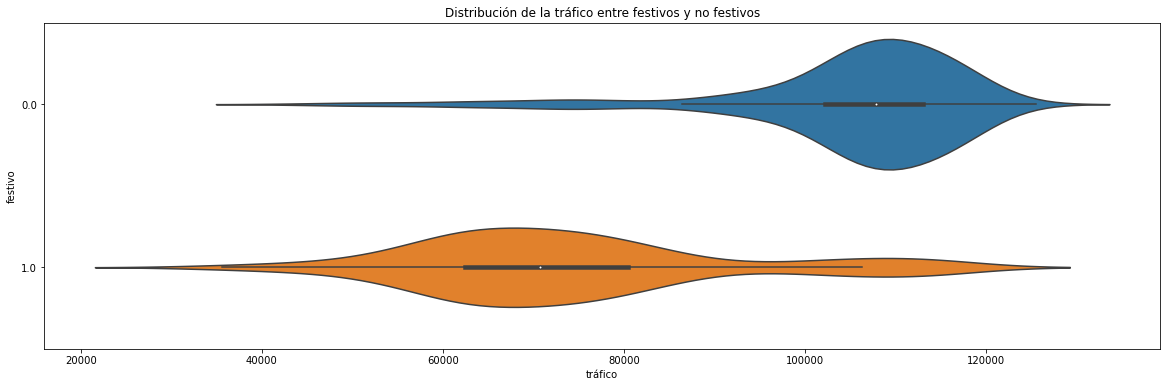

In [84]:
# Grafico violinplot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
sns.violinplot(
    x       = 'cantidad_pasos',
    y       = 'feriado',
    data    = diario_ds_corregido_f.assign(feriado = diario_ds_corregido_f.feriado.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la tráfico entre festivos y no festivos')
ax.set_xlabel('tráfico')
ax.set_ylabel('festivo');

Los días festivos tienden a tener menor tráfico.

### 11.1.2 Separación datos train-val-test

In [88]:
fin_train = '2019-06-30'
inicio_validacion = '2019-07-01'
fin_validacion = '2019-09-30'
inicio_test = '2019-10-01'

diario_ds_corregido_f_train = diario_ds_corregido_f.loc[:fin_train, :]
diario_ds_corregido_f_val   = diario_ds_corregido_f.loc[inicio_validacion:fin_validacion, :]
diario_ds_corregido_f_test  = diario_ds_corregido_f.loc[inicio_test:, :]

print(f"Fechas train      : {diario_ds_corregido_f_train.index.min()} --- {diario_ds_corregido_f_train.index.max()}")
print(f"Fechas validación : {diario_ds_corregido_f_val.index.min()} --- {diario_ds_corregido_f_val.index.max()}")
print(f"Fechas test       : {diario_ds_corregido_f_test.index.min()} --- {diario_ds_corregido_f_test.index.max()}")

col_exog = diario_ds_corregido_f.copy()
col_exog = col_exog.drop(columns=['cantidad_pasos'])
col_exog = col_exog.columns

#col_exog = ['month','dow','laboral','feriado','feriado_e','cantidad_pasos_aa','month_aa','dow_aa','laboral_aa','feriado_aa','feriado_e_aa']


Fechas train      : 2018-03-26 00:00:00 --- 2019-06-30 00:00:00
Fechas validación : 2019-07-01 00:00:00 --- 2019-09-30 00:00:00
Fechas test       : 2019-10-01 00:00:00 --- 2019-12-31 00:00:00


## 11.2 Modelo 5: ForecasterAutoreg con variable exogena, regresor Random Forest
#### 11.2.1 Modelo 5: Entrenamiento

In [89]:
# Creación y entrenamiento forecaster
forecaster_f_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=42),
                    lags=84
                )


forecaster_f_rf.fit(y=diario_ds_corregido_f_train['cantidad_pasos'],exog=diario_ds_corregido_f_train[col_exog])

forecaster_f_rf

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(random_state=42)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84]
Exogenous variable: True, <class 'pandas.core.frame.DataFrame'>
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

#### 11.2.1 Modelo 5: Predicción

In [90]:
# Backtest
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster_f_rf,
                            y          = diario_ds_corregido_f.cantidad_pasos,
                            exog       = diario_ds_corregido_f[col_exog],
                            initial_train_size = len(diario_ds_corregido_f.loc[:fin_validacion,:]),
                            steps      = 1,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Se añade el índice temporal a las predicciones
predicciones = pd.DataFrame(data=predicciones, index=diario_ds_corregido_f_test.index, columns=['cantidad_pasos'])
print(f'Error backtest: {metrica}')

Number of observations used for training: 554
Number of observations used for testing: 92
    Number of folds: 92
    Number of steps per fold: 1
Error backtest: [11958.41836957]


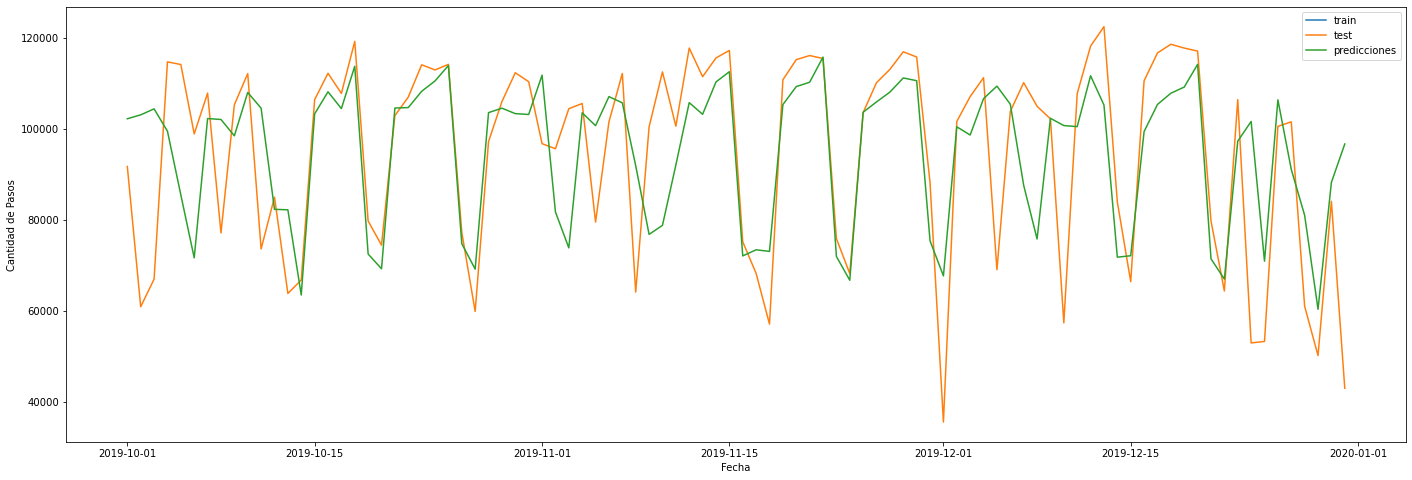

In [91]:
# Gráfico
plt.figure(figsize = (24,8))
plt.plot(diario_ds_corregido_f_train.loc[diario_ds_corregido_f_train.index.strftime('%Y-%m-%d')>='2019-08-01'].index, diario_ds_corregido_f_train.loc[diario_ds_corregido_f_train.index.strftime('%Y-%m-%d')>='2019-08-01'].cantidad_pasos, label = 'train')
plt.plot(diario_ds_corregido_f_test.index, diario_ds_corregido_f_test.cantidad_pasos, label = 'test')
plt.plot(predicciones.index, predicciones.cantidad_pasos, label = 'predicciones')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

#### 11.2.3 Modelo 5: Error

In [92]:
#Calculamos la raíz del error cuadratico medio (rmse) para train y test
rmse_test_tree = np.sqrt(mean_squared_error(diario_ds_corregido_f_test.cantidad_pasos, predicciones))

#Calculamos el error r2_score
r2_test_tree = r2_score(diario_ds_corregido_f_test.cantidad_pasos, predicciones)

#Calculamos el MAE
mae_test_tree = mean_absolute_error(diario_ds_corregido_f_test.cantidad_pasos, predicciones)

print(f'Raíz del error cuadrático medio en Test: {rmse_test_tree}')
print(f'R2 en Test: {r2_test_tree}')
print(f'MAE en Test: {mae_test_tree}')

nueva_fila = { 'Modelo': 'ForecasterAutoreg w/ Random Forest & Exogena', 'R2': r2_test_tree, 'RMSE': rmse_test_tree, 'MAE': mae_test_tree} # creamos un diccionario
modelos = modelos.append(nueva_fila, ignore_index=True)
modelos

Raíz del error cuadrático medio en Test: 16902.32787661944
R2 en Test: 0.3996294784721611
MAE en Test: 11958.418369565217


,Modelo,R2,RMSE,MAE
0,Bechmark ForecasterAutoreg w/ Random Forest,0.207594,19418.277410,13846.689565
1,Bechmark ForecasterAutoreg w/ Ridge,0.192303,19604.738626,15084.833386
2,Bechmark Optimizado ForecasterAutoreg w/ Rando...,0.268634,18655.391091,12889.562294
3,Bechmark Optimizado ForecasterAutoreg w/ Ridge,0.244758,18957.454700,14944.462105
4,ForecasterAutoreg w/ Random Forest & Exogena,0.399629,16902.327877,11958.418370


#### 11.2.4 Importancia predictores

In [93]:
# Importancia predictores
impotancia = forecaster_f_rf.get_feature_importances()
dict(zip(forecaster_f_rf.lags, impotancia))

{1: 0.031242930128440493,
 2: 0.01549252408729105,
 3: 0.015040980784428138,
 4: 0.003971169010649502,
 5: 0.005582789384603979,
 6: 0.0026749763847191037,
 7: 0.0014847226123622325,
 8: 0.0025170915515952226,
 9: 0.003522369115330952,
 10: 0.001405948900711712,
 11: 0.0018467172509606935,
 12: 0.0010489602970954542,
 13: 0.0010412669644246798,
 14: 0.006286293203624974,
 15: 0.0030716150934304853,
 16: 0.0039942453136312586,
 17: 0.0034483957835200613,
 18: 0.0022541071895524002,
 19: 0.0014210460260567727,
 20: 0.003334320293531369,
 21: 0.002438614431063214,
 22: 0.006974445748911432,
 23: 0.007254961240486975,
 24: 0.0041192710773142,
 25: 0.001999685070267896,
 26: 0.007995683215640087,
 27: 0.010842312192911206,
 28: 0.014073539813041895,
 29: 0.005951586615238899,
 30: 0.005638325715356107,
 31: 0.003162938402615846,
 32: 0.003268909588104322,
 33: 0.0037376170717413025,
 34: 0.004199307982679544,
 35: 0.003506628329682938,
 36: 0.01669191448946775,
 37: 0.003918429556118134,
 3

## 11.3. Modelo 6: ForecasterAutoreg con variable exogena, regresor Random Forest y Optimización de Hiperparametros

In [156]:
# Grid search de hiperparámetros
forecaster_f_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=42, n_jobs=-1),
                    lags      = 84 # Este valor será remplazado en el grid search
                 )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3,5,10,15,20,None],
              'min_samples_split': [2, 5, 10],
             }

# Lags utilizados como predictores
lags_grid = [231, 84, 56]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_f_rf,
                        y           = diario_ds_corregido_f.loc[:fin_validacion, 'cantidad_pasos'],
                        exog        = diario_ds_corregido_f.loc[:fin_validacion][col_exog],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 7,
                        method      = 'cv',
                        metric      = 'mean_absolute_error',
                        initial_train_size    = len(diario_ds_corregido_f_train),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                   )

2021-10-02 11:01:46,572 root       INFO  Number of models compared: 162
loop lags_grid: 100%|██████████| 3/3 [1:13:59<00:00, 1479.97s/it][A
2021-10-02 12:15:46,525 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56] 
params: {'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 50}



In [157]:
resultados_grid

,lags,params,metric,max_depth,min_samples_split,n_estimators
114,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'min_samples_split': 10, 'n_e...",10572.733019,3.0,10.0,50.0
108,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'min_samples_split': 2, 'n_es...",10604.175048,3.0,2.0,50.0
111,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'min_samples_split': 5, 'n_es...",10606.919703,3.0,5.0,50.0
132,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'min_samples_split': 10, 'n_...",10652.336578,10.0,10.0,50.0
130,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'min_samples_split': 5, 'n_e...",10654.807827,10.0,5.0,100.0
...,...,...,...,...,...,...
52,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': None, 'min_samples_split': 10, '...",11804.102089,NaN,10.0,100.0
34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'min_samples_split': 10, 'n_...",11810.384135,15.0,10.0,100.0
40,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'min_samples_split': 5, 'n_e...",11810.408963,20.0,5.0,100.0
49,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': None, 'min_samples_split': 5, 'n...",11813.750973,NaN,5.0,100.0


#### 11.3.1 Modelo 6: Entrenamiento

In [94]:
# Crear y entrenar forecaster con mejores hiperparámetros
regressor_f = RandomForestRegressor(max_depth=3, n_estimators=50,min_samples_split = 10, random_state=42)
#
forecaster_f_rf = ForecasterAutoreg(
                    regressor = regressor_f,
                    lags      = 56
                )

forecaster_f_rf.fit(y=diario_ds_corregido_f_train['cantidad_pasos'],exog=diario_ds_corregido_f_train[col_exog])

forecaster_f_rf

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(max_depth=3, min_samples_split=10, n_estimators=50,
                      random_state=42)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56]
Exogenous variable: True, <class 'pandas.core.frame.DataFrame'>
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

#### 11.3.2 Modelo 6: Predicción

In [95]:
# Backtest
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster_f_rf,
                            y          = diario_ds_corregido_f.cantidad_pasos,
                            exog       = diario_ds_corregido_f[col_exog],
                            initial_train_size = len(diario_ds_corregido_f.loc[:fin_validacion,:]),
                            steps      = 1,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Se añade el índice temporal a las predicciones
predicciones = pd.DataFrame(data=predicciones, index=diario_ds_corregido_f_test.index, columns=['cantidad_pasos'])
print(f'Error backtest: {metrica}')

Number of observations used for training: 554
Number of observations used for testing: 92
    Number of folds: 92
    Number of steps per fold: 1
Error backtest: [12361.14780756]


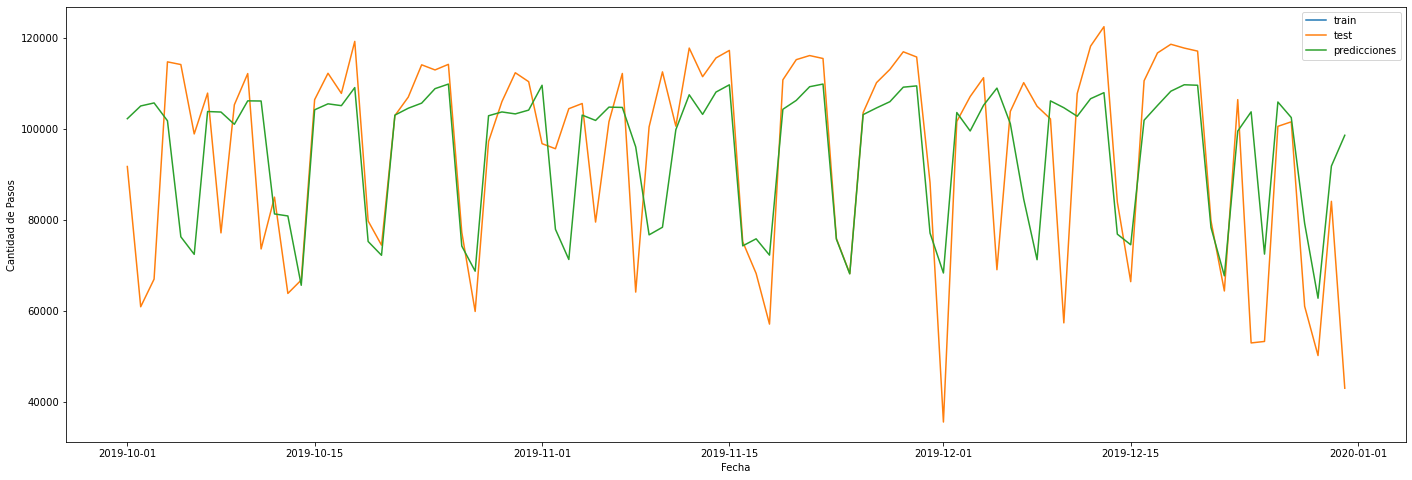

In [96]:
# Gráfico
plt.figure(figsize = (24,8))
plt.plot(diario_ds_corregido_f_train.loc[diario_ds_corregido_f_train.index.strftime('%Y-%m-%d')>='2019-08-01'].index, diario_ds_corregido_f_train.loc[diario_ds_corregido_f_train.index.strftime('%Y-%m-%d')>='2019-08-01'].cantidad_pasos, label = 'train')
plt.plot(diario_ds_corregido_f_test.index, diario_ds_corregido_f_test.cantidad_pasos, label = 'test')
plt.plot(predicciones.index, predicciones.cantidad_pasos, label = 'predicciones')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

#### 11.3.3 Modelo 6: Error

In [97]:
#Calculamos la raíz del error cuadratico medio (rmse) para train y test
rmse_test_tree = np.sqrt(mean_squared_error(diario_ds_corregido_f_test.cantidad_pasos, predicciones))

#Calculamos el error r2_score
r2_test_tree = r2_score(diario_ds_corregido_f_test.cantidad_pasos, predicciones)

#Calculamos el MAE
mae_test_tree = mean_absolute_error(diario_ds_corregido_f_test.cantidad_pasos, predicciones)

print(f'Raíz del error cuadrático medio en Test: {rmse_test_tree}')
print(f'R2 en Test: {r2_test_tree}')
print(f'MAE en Test: {mae_test_tree}')

nueva_fila = { 'Modelo': 'Optimizado ForecasterAutoreg w/ RandomForest & Exogena', 'R2': r2_test_tree, 'RMSE': rmse_test_tree, 'MAE': mae_test_tree} # creamos un diccionario
modelos = modelos.append(nueva_fila, ignore_index=True)
modelos

Raíz del error cuadrático medio en Test: 17716.01067852535
R2 en Test: 0.34043411744554697
MAE en Test: 12361.147807561932


,Modelo,R2,RMSE,MAE
0,Bechmark ForecasterAutoreg w/ Random Forest,0.207594,19418.277410,13846.689565
1,Bechmark ForecasterAutoreg w/ Ridge,0.192303,19604.738626,15084.833386
2,Bechmark Optimizado ForecasterAutoreg w/ Rando...,0.268634,18655.391091,12889.562294
3,Bechmark Optimizado ForecasterAutoreg w/ Ridge,0.244758,18957.454700,14944.462105
4,ForecasterAutoreg w/ Random Forest & Exogena,0.399629,16902.327877,11958.418370
5,Optimizado ForecasterAutoreg w/ RandomForest &...,0.340434,17716.010679,12361.147808


#### 11.3.4 Importancia predictores

In [98]:
# Importancia predictores
impotancia = forecaster_f_rf.get_feature_importances()
dict(zip(forecaster_f_rf.lags, impotancia))

{1: 0.008837770742714914,
 2: 0.01669933477634531,
 3: 0.010046207802975222,
 4: 0.0043053886272203514,
 5: 0.005026683136794987,
 6: 0.0006035834457460079,
 7: 0.00022404890340629099,
 8: 0.002328522626950356,
 9: 0.001796558214303048,
 10: 0.0,
 11: 0.0007551773128754747,
 12: 0.0010082815336697715,
 13: 0.0008297772351904963,
 14: 0.0,
 15: 0.002494083893983361,
 16: 0.0007768138440846448,
 17: 0.004592016100739027,
 18: 0.0,
 19: 0.0009347501297772375,
 20: 0.00164036779405029,
 21: 0.0002181865005270583,
 22: 0.004143408740306806,
 23: 0.0009723741193252034,
 24: 0.002143189600394598,
 25: 0.001452024357863376,
 26: 0.0021779815041700385,
 27: 0.0023350269760977578,
 28: 0.008477057185132463,
 29: 0.0035021076386348195,
 30: 0.0017739341030109316,
 31: 0.005053190266687759,
 32: 0.0006397965097974313,
 33: 0.0043004315028674,
 34: 0.002387478144721959,
 35: 0.0023816790139949994,
 36: 0.019365676654965074,
 37: 0.0023929736874218474,
 38: 0.0,
 39: 0.0029325018062255816,
 40: 0.04

In [96]:
modelos

,Modelo,R2,RMSE,MAE
0,Bechmark ForecasterAutoreg w/ Random Forest,0.207594,19418.277410,13846.689565
1,Bechmark ForecasterAutoreg w/ Ridge,0.192303,19604.738626,15084.833386
2,Bechmark Optimizado ForecasterAutoreg w/ Rando...,0.268634,18655.391091,12889.562294
3,Bechmark Optimizado ForecasterAutoreg w/ Ridge,0.244758,18957.454700,14944.462105
4,ForecasterAutoreg w/ Random Forest & Exogena,0.399629,16902.327877,11958.418370
5,Optimizado ForecasterAutoreg w/ RandomForest &...,0.340434,17716.010679,12361.147808


## 11.4 Conclusiones (Parte 2)
- Aunque las metricas de error continuan siendo altas, existe una mejora en los resultados obtenidos en la sección 11 respecto a la sección 10, como puede observarse en los resultados obtenidos. 
- El mejor modelo resultado se obtienen para el modelo NO optimizado ForecasterAutoreg con variables exógenas y el regresor RandomForest, con un MAE de 11958.42
- Para la importancia de los predictores se puede observar, en general y a diferencia de los resultados obtenidos en la sección 10, no existen Lags que representen un mayor porcenteje en la predicción realizada, esto se debe a la incorporación de las variables exógenas dentro de los modelos.

# 12. Modelo direct multi-step

Los modelos ForecasterAutoreg siguen una estrategia de predicción recursiva en la que, cada nueva predicción, se basa en la predicción anterior. Una alternativa es entrenar un modelo para cada uno de los steps que se desea predecir, lo que se conoce como direct multi-step forecasting. Si bien es computacionalmente más costosa que la recursiva, puesto que requiere entrenar múltiples modelos, en algunos escenarios, consigue mejores resultados. Este tipo de modelos pueden obtenerse con la clase ForecasterAutoregMultiOutput y pueden incluir también una o múltiples variables exógenas.<br/><br/>

A diferencia de cuando se utiliza ForecasterAutoreg, en los modelos de tipo ForecasterAutoregMultiOutput hay que indicar, en el momento de su creación, el número de steps que se quieren predecir. Esto significa que, el número de predicciones obtenidas al ejecutar la predicción, es siempre el mismo.

In [99]:
fin_train = '2019-06-30'
inicio_validacion = '2019-07-01'
fin_validacion = '2019-09-30'
inicio_test = '2019-10-01'

diario_ds_corregido_f_train = diario_ds_corregido_f.loc[:fin_train, :]
diario_ds_corregido_f_val   = diario_ds_corregido_f.loc[inicio_validacion:fin_validacion, :]
diario_ds_corregido_f_test  = diario_ds_corregido_f.loc[inicio_test:, :]

print(f"Fechas train      : {diario_ds_corregido_f_train.index.min()} --- {diario_ds_corregido_f_train.index.max()}")
print(f"Fechas validación : {diario_ds_corregido_f_val.index.min()} --- {diario_ds_corregido_f_val.index.max()}")
print(f"Fechas test       : {diario_ds_corregido_f_test.index.min()} --- {diario_ds_corregido_f_test.index.max()}")

#col_exog = ['month','dow','laboral','feriado','feriado_e']

col_exog = diario_ds_corregido_f.copy()
col_exog = col_exog.drop(columns=['cantidad_pasos'])
col_exog = col_exog.columns

diario_ds_corregido_f_test

Fechas train      : 2018-03-26 00:00:00 --- 2019-06-30 00:00:00
Fechas validación : 2019-07-01 00:00:00 --- 2019-09-30 00:00:00
Fechas test       : 2019-10-01 00:00:00 --- 2019-12-31 00:00:00


,cantidad_pasos,month_ene,month_feb,month_mar,month_abr,month_may,month_jun,month_jul,month_ago,month_sep,...,dow_lun_aa,dow_mar_aa,dow_mie_aa,dow_jue_aa,dow_vie_aa,dow_sab_aa,dow_dom_aa,laboral_aa,feriado_aa,feriado_e_aa
fecha,,,,,,,,,,,,,,,,,,,,,
2019-10-01,91688.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2019-10-02,60897.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2019-10-03,66961.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2019-10-04,114669.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2019-10-05,114076.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,101501.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2019-12-28,60999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2019-12-29,50185.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Para este modelo se utilizará un step de 7, debido al comportamiento semanal de los datos. 

In [180]:
# Grid search de hiperparámetros
forecaster = ForecasterAutoregMultiOutput(
                regressor = RandomForestRegressor(random_state=42, n_jobs=-1),
                steps     = 7,
                lags      = 28 # Este valor será remplazado en el grid search
             )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3,5,10,15,20,None],
              'min_samples_split': [2, 5, 10],
             }

# Lags utilizados como predictores
lags_grid = [56, 84]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = diario_ds_corregido_f.loc[:fin_validacion, 'cantidad_pasos'],
                        exog        = diario_ds_corregido_f.loc[:fin_validacion, col_exog],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 7,
                        metric      = 'mean_absolute_error',
                        method      = 'cv',
                        initial_train_size = len(diario_ds_corregido_f.loc[:fin_train]),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                  )

2021-10-02 13:59:24,975 root       INFO  Number of models compared: 108
loop lags_grid: 100%|██████████| 2/2 [4:41:21<00:00, 8440.55s/it]  
2021-10-02 18:40:46,109 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84] 
params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}



### 12.1.1 Modelo 7: Entrenamiento

In [100]:
# Crear y entrenar forecaster con mejores hiperparámetros
regressor_f = RandomForestRegressor(max_depth=None, n_estimators=50,min_samples_split = 10, random_state=42,n_jobs=-1)
#
forecaster_rf = ForecasterAutoregMultiOutput (
                    regressor = regressor_f,
                    steps     = 7,
                    lags      = 84 # Este valor será remplazado en el grid search
                )

forecaster_rf.fit(y=diario_ds_corregido_f_train['cantidad_pasos'],exog=diario_ds_corregido_f_train[col_exog])

forecaster_rf




============================ForecasterAutoregMultiOutput============================
Regressor: RandomForestRegressor(min_samples_split=10, n_estimators=50, n_jobs=-1,
                      random_state=42)
Steps: 7
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84]
Exogenous variable: True, <class 'pandas.core.frame.DataFrame'>
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

### 12.1.2 Modelo 7: Predicción

In [101]:
# Backtest
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster_rf,
                            y          = diario_ds_corregido_f.cantidad_pasos,
                            exog       = diario_ds_corregido_f[col_exog],
                            initial_train_size = len(diario_ds_corregido_f.loc[:fin_validacion,:]),
                            steps      = 7,
                            metric     = 'mean_absolute_error',                            
                            verbose    = True
                        )

# Se añade el índice temporal a las predicciones
#predicciones = forecaster_rf.predict(steps=7, exog=diario_ds_corregido_test[col_exog])
#predicciones

predicciones = pd.DataFrame(data=predicciones, index=diario_ds_corregido_f_test.loc[:"2019-12-30",:].index, columns=['cantidad_pasos'])
print(f'Error backtest: {metrica}')

predicciones


2021-10-05 01:08:33,154 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 1 observations are excluded.


Number of observations used for training: 554
Number of observations used for testing: 92
    Number of folds: 13
    Number of steps per fold: 7
Error backtest: [11776.09883013]


,cantidad_pasos
fecha,
2019-10-01,101989.132560
2019-10-02,105966.208104
2019-10-03,106826.941156
2019-10-04,105859.781179
2019-10-05,79307.775438
...,...
2019-12-26,108660.984955
2019-12-27,95459.370601
2019-12-28,78252.210193


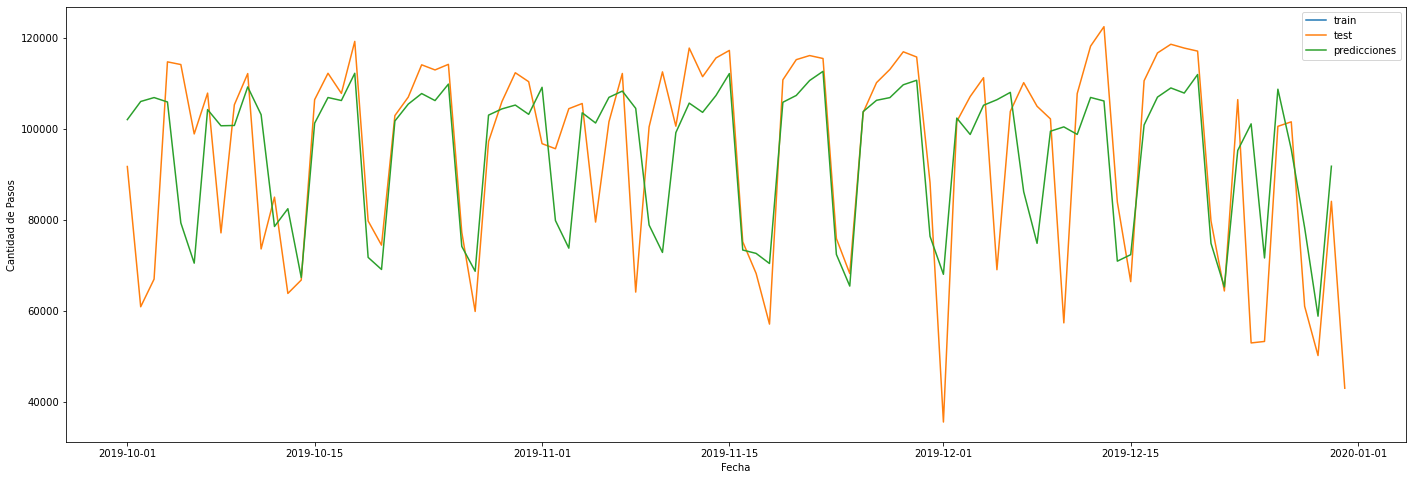

In [102]:
# Gráfico
plt.figure(figsize = (24,8))
plt.plot(diario_ds_corregido_train.loc[diario_ds_corregido_train.index.strftime('%Y-%m-%d')>='2019-08-01'].index, diario_ds_corregido_train.loc[diario_ds_corregido_train.index.strftime('%Y-%m-%d')>='2019-08-01'].cantidad_pasos, label = 'train')
plt.plot(diario_ds_corregido_test.index, diario_ds_corregido_test.cantidad_pasos, label = 'test')
plt.plot(predicciones.index, predicciones.cantidad_pasos, label = 'predicciones')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

### 12.1.3 Modelo 7: Error

In [103]:
#Calculamos la raíz del error cuadratico medio (rmse) para train y test
rmse_test_tree = np.sqrt(mean_squared_error(diario_ds_corregido_test.loc[:"2019-12-30"].cantidad_pasos, predicciones))

#Calculamos el error r2_score
r2_test_tree = r2_score(diario_ds_corregido_test.loc[:"2019-12-30"].cantidad_pasos, predicciones)

#Calculamos el MAE
mae_test_tree = mean_absolute_error(diario_ds_corregido_test.loc[:"2019-12-30"].cantidad_pasos, predicciones)

print(f'Raíz del error cuadrático medio en Test: {rmse_test_tree}')
print(f'R2 en Test: {r2_test_tree}')
print(f'MAE en Test: {mae_test_tree}')

nueva_fila = { 'Modelo': 'Optimizado ForecasterAutoreg Multi w/ RandomForest & Exogena', 'R2': r2_test_tree, 'RMSE': rmse_test_tree, 'MAE': mae_test_tree} # creamos un diccionario
modelos = modelos.append(nueva_fila, ignore_index=True)
modelos

Raíz del error cuadrático medio en Test: 16562.681991059504
R2 en Test: 0.39225300375519856
MAE en Test: 11776.098830126137


,Modelo,R2,RMSE,MAE
0,Bechmark ForecasterAutoreg w/ Random Forest,0.207594,19418.277410,13846.689565
1,Bechmark ForecasterAutoreg w/ Ridge,0.192303,19604.738626,15084.833386
2,Bechmark Optimizado ForecasterAutoreg w/ Rando...,0.268634,18655.391091,12889.562294
3,Bechmark Optimizado ForecasterAutoreg w/ Ridge,0.244758,18957.454700,14944.462105
4,ForecasterAutoreg w/ Random Forest & Exogena,0.399629,16902.327877,11958.418370
5,Optimizado ForecasterAutoreg w/ RandomForest &...,0.340434,17716.010679,12361.147808
6,Optimizado ForecasterAutoreg Multi w/ RandomFo...,0.392253,16562.681991,11776.098830


#### 12.1.4 Importancia predictores

In [104]:
# Importancia predictores
impotancia = forecaster_rf.get_feature_importances(step=7)
dict(zip(forecaster_rf.lags, impotancia))

{1: 0.0009014909207024603,
 2: 0.003211372171949722,
 3: 0.009355451986178561,
 4: 0.0014957760883746705,
 5: 0.00435745737248006,
 6: 0.0013311022854991278,
 7: 0.001432498465950828,
 8: 0.00458502309301991,
 9: 0.0025990380320083857,
 10: 0.0031103053484524286,
 11: 0.0042713130921232965,
 12: 0.0012268720627777155,
 13: 0.003705679343004433,
 14: 0.002919150660303855,
 15: 0.0014568697466661859,
 16: 0.008355922253606325,
 17: 0.008576010381369134,
 18: 0.002584903084003661,
 19: 0.0008729043810627617,
 20: 0.008923818558792885,
 21: 0.0068227272975977145,
 22: 0.01467143032520888,
 23: 0.005690338743145241,
 24: 0.005098389000343187,
 25: 0.004541953547656627,
 26: 0.0031879824463642028,
 27: 0.0037176364161493835,
 28: 0.004593895172141123,
 29: 0.002549552776699975,
 30: 0.012836444264195165,
 31: 0.00687137059630951,
 32: 0.0041819173220157425,
 33: 0.003985657483484938,
 34: 0.03518648460813961,
 35: 0.005953545279335412,
 36: 0.0005959656110308563,
 37: 0.0011670817028804938,


## 13. Conclusiones Generales

- El mejor modelo es el Modelo direct multi-step optimizado con el regresor RandomForest con un MAE de 11776.1. 
- En general los modelos entrenados en las secciones 10, 11 y 12 no obtuvieron buenas metricas de error, no superando el 0.4 de la metrica de error R2, ni bajando el MAE considerablemente desde 13846.7 (Benchmark) a 11776 (Modelo Optimizado direct multi-step).
    - Sección 10: Modelo Optimizado ForecasterAutoreg con Random Forest. MAE: 12889.6
    - Sección 11: Modelo ForescasterAutoref con Random Forest y variable exógena. MAE: 11958.4
    - Sección 12: Modelo Optimizado direct multi-step con Random Forest y variable exógena. MAE: 11776.1
- Las variables exógenas contienen la caracterización del día (Día de la semana, mes, laboral o feriado), sumando a las datos del mismo día de la semana para 12 semanas anteriores y el año anterior. Es por esto que la importancia de los predictores, correspondiente a los lags, para los modelos donde se utiliza variable exógena, no contienen un porcentaje representativo al momento de realizar las predicciones.
- Existen algunas variables exógenas que no se incorporaron debido a lo complejo de implementar en esta primera etapa como: situación politicia-social y clima del día. 
- La incorporación de variables exógenas mejoró los resultados en aproxidamente 20 puntos, respecto a R2, desde 0.2 a 0.4.
- Para mejorar la predicción puede ser necesario probar con algunas alternativas
    - Agrupar los datos de tráfico vehicular por semana y predecir el trafico vehicular para una semana completa. Luego aplicar a la predicción una distribución historica diaria o la distribución de las ultimas cuatro semanas. Cuando exista un feriado durante la semana, este se distribuirá, por lo que solo sería necesario conocer la cantidad de feriados y feriados especiales existentes en la semana.
    - Realizar un Modelo de Blending utilizando las tres mejores predicciones obtenidas en el presente documento.
    - Realizar una predicción utilizando el dataset con las variables exógenas y modelos de redes neuronales.
    - Para cualquiera de los Modelos utilizados buscar aquellos modelos donde se sobrestime y se subestime la predicción, con el fin de promediar los resultados y obtener una predicción mejor de los datos.

Para el siguiente proyecto se estudiará el trabajo con Redes Neuronales, más en especifico el trabajo con Tensor Flow y las series de Tiempo como se puede ver en las siguientes páginas <a href="https://www.tensorflow.org/tutorials/structured_data/time_series" target="_blank">Tensor Flow - Pronóstico de series de tiempo</a> y <a href="https://towardsdatascience.com/time-series-forecasting-using-tensorflow-and-deep-hybrid-learning-5088ad76dd55" target="_blank">Time Series Forecasting using TensorFlow and Deep Hybrid Learning</a>, utilizando el dataset diario_ds_corregido_f (previamente exportado a un archivo csv) que continene en cada columna la cantidad de tráfico vehicular, la información del día, la información de tráfico y del día para las 12 semanas anteriores y la información del año anterior para la misma fecha. Con este dataset, previamente construido en el presente documento, se pretende obtener un modelo que pueda confluir en una predicción que pueda mejorar el Error Medio Absoluto (MAE), se espera que como minimo el error baje los 10.000 puntos. <br/>
Se estima que para esto será necesario utilizar los tres mejores modelos del presente documento para realizar una técnina de Blending, con el fin de minimizar el error y comparar resultados.

## 14. Anexo: Modelo Blending
Se utilizaran las tres mejores predicciones obtenidas y luego se realizará un Modelo Blending 

In [106]:
modelos

,Modelo,R2,RMSE,MAE
0,Bechmark ForecasterAutoreg w/ Random Forest,0.207594,19418.277410,13846.689565
1,Bechmark ForecasterAutoreg w/ Ridge,0.192303,19604.738626,15084.833386
2,Bechmark Optimizado ForecasterAutoreg w/ Rando...,0.268634,18655.391091,12889.562294
3,Bechmark Optimizado ForecasterAutoreg w/ Ridge,0.244758,18957.454700,14944.462105
4,ForecasterAutoreg w/ Random Forest & Exogena,0.399629,16902.327877,11958.418370
5,Optimizado ForecasterAutoreg w/ RandomForest &...,0.340434,17716.010679,12361.147808
6,Optimizado ForecasterAutoreg Multi w/ RandomFo...,0.392253,16562.681991,11776.098830


Se utilizaran los tres ultimos modelos: 4, 5 y 6

In [105]:
# Creación y entrenamiento forecaster
modelo4 = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=42),
                    lags=84
                )


modelo4.fit(y=diario_ds_corregido_f_train['cantidad_pasos'],exog=diario_ds_corregido_f_train[col_exog])

metrica4, predicciones4 = backtesting_forecaster(
                            forecaster = modelo4,
                            y          = diario_ds_corregido_f.cantidad_pasos,
                            exog       = diario_ds_corregido_f[col_exog],
                            initial_train_size = 168,
                            steps      = 1,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )
predicciones4 = pd.DataFrame(data=predicciones4, index=diario_ds_corregido_f.iloc[168:,:].index, columns=['cantidad_pasos'])
predicciones4


Number of observations used for training: 168
Number of observations used for testing: 478
    Number of folds: 478
    Number of steps per fold: 1


,cantidad_pasos
fecha,
2018-09-10,105368.00
2018-09-11,106227.82
2018-09-12,111235.71
2018-09-13,107328.54
2018-09-14,115284.57
...,...
2019-12-27,109195.90
2019-12-28,72428.34
2019-12-29,66220.66


In [106]:
# Crear y entrenar forecaster con mejores hiperparámetros
regressor_f = RandomForestRegressor(max_depth=3, n_estimators=50,min_samples_split = 10, random_state=42)
#
modelo5 = ForecasterAutoreg(
                    regressor = regressor_f,
                    lags      = 56
                )

modelo5.fit(y=diario_ds_corregido_f_train['cantidad_pasos'],exog=diario_ds_corregido_f_train[col_exog])

metrica5, predicciones5 = backtesting_forecaster(
                            forecaster = modelo5,
                            y          = diario_ds_corregido_f.cantidad_pasos,
                            exog       = diario_ds_corregido_f[col_exog],
                            initial_train_size = 112,
                            steps      = 1,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

predicciones5 = pd.DataFrame(data=predicciones5, index=diario_ds_corregido_f.iloc[112:,:].index, columns=['cantidad_pasos'])
predicciones5

Number of observations used for training: 112
Number of observations used for testing: 534
    Number of folds: 534
    Number of steps per fold: 1


,cantidad_pasos
fecha,
2018-07-16,107909.104662
2018-07-17,109627.700082
2018-07-18,108941.008910
2018-07-19,113480.070511
2018-07-20,111959.137485
...,...
2019-12-27,113571.119723
2019-12-28,70495.875246
2019-12-29,62943.016053


In [107]:
# Crear y entrenar forecaster con mejores hiperparámetros
regressor_f = RandomForestRegressor(max_depth=None, n_estimators=50,min_samples_split = 10, random_state=42,n_jobs=-1)
#
modelo6 = ForecasterAutoregMultiOutput (
                    regressor = regressor_f,
                    steps     = 7,
                    lags      = 84 # Este valor será remplazado en el grid search
                )

modelo6.fit(y=diario_ds_corregido_f_train['cantidad_pasos'],exog=diario_ds_corregido_f_train[col_exog])

metrica6, predicciones6 = backtesting_forecaster(
                            forecaster = modelo6,
                            y          = diario_ds_corregido_f.cantidad_pasos,
                            exog       = diario_ds_corregido_f[col_exog],
                            initial_train_size = 168,
                            steps      = 7,
                            metric     = 'mean_absolute_error',                            
                            verbose    = True
                        )

predicciones6 = pd.DataFrame(data=predicciones6, index=diario_ds_corregido_f.iloc[168:-2,:].index, columns=['cantidad_pasos'])
predicciones6

2021-10-05 01:08:56,610 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 2 observations are excluded.


Number of observations used for training: 168
Number of observations used for testing: 478
    Number of folds: 68
    Number of steps per fold: 7


,cantidad_pasos
fecha,
2018-09-10,104610.454152
2018-09-11,107958.293692
2018-09-12,107824.463251
2018-09-13,109893.837264
2018-09-14,114223.208712
...,...
2019-12-25,63455.100328
2019-12-26,109777.214806
2019-12-27,113868.999543


In [108]:
diario_ds_corregido_fb = diario_ds_corregido_f.loc['2018-09-10':'2019-12-29',:]
diario_ds_corregido_fb['cantidad_pasos_m4'] = predicciones4.loc['2018-09-10':'2019-12-29',:].cantidad_pasos
diario_ds_corregido_fb['cantidad_pasos_m5'] = predicciones5.loc['2018-09-10':'2019-12-29',:].cantidad_pasos
diario_ds_corregido_fb['cantidad_pasos_m6'] = predicciones6.loc['2018-09-10':'2019-12-29',:].cantidad_pasos

In [109]:
fin_train = '2019-06-30'
inicio_validacion = '2019-07-01'
fin_validacion = '2019-09-30'
inicio_test = '2019-10-01'

diario_ds_corregido_fb_train = diario_ds_corregido_fb.loc[:fin_train, :]
diario_ds_corregido_fb_val   = diario_ds_corregido_fb.loc[inicio_validacion:fin_validacion, :]
diario_ds_corregido_fb_test  = diario_ds_corregido_fb.loc[inicio_test:, :]

print(f"Fechas train      : {diario_ds_corregido_fb_train.index.min()} --- {diario_ds_corregido_fb_train.index.max()}")
print(f"Fechas validación : {diario_ds_corregido_fb_val.index.min()} --- {diario_ds_corregido_fb_val.index.max()}")
print(f"Fechas test       : {diario_ds_corregido_fb_test.index.min()} --- {diario_ds_corregido_fb_test.index.max()}")

col_exog = diario_ds_corregido_fb.copy()
col_exog = col_exog.drop(columns=['cantidad_pasos'])
col_exog = col_exog.columns

diario_ds_corregido_fb_test

Fechas train      : 2018-09-10 00:00:00 --- 2019-06-30 00:00:00
Fechas validación : 2019-07-01 00:00:00 --- 2019-09-30 00:00:00
Fechas test       : 2019-10-01 00:00:00 --- 2019-12-29 00:00:00


,cantidad_pasos,month_ene,month_feb,month_mar,month_abr,month_may,month_jun,month_jul,month_ago,month_sep,...,dow_jue_aa,dow_vie_aa,dow_sab_aa,dow_dom_aa,laboral_aa,feriado_aa,feriado_e_aa,cantidad_pasos_m4,cantidad_pasos_m5,cantidad_pasos_m6
fecha,,,,,,,,,,,,,,,,,,,,,
2019-10-01,91688.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,105894.91,109266.167850,108656.453008
2019-10-02,60897.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,105479.11,108975.429055,107608.112017
2019-10-03,66961.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,106095.05,108984.117715,109154.018773
2019-10-04,114669.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,106827.47,111466.635656,111457.512879
2019-10-05,114076.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,75892.63,64318.069006,75518.551715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,53281.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,62288.21,65257.197834,63455.100328
2019-12-26,100511.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,107190.35,114139.762880,109777.214806
2019-12-27,101501.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,109195.90,113571.119723,113868.999543


In [110]:
# Creación y entrenamiento forecaster
modelob = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=42),
                    lags=84
                )


modelob.fit(y=diario_ds_corregido_fb_train['cantidad_pasos'],exog=diario_ds_corregido_fb_train[col_exog])

metricab, prediccionesb = backtesting_forecaster(
                            forecaster = modelob,
                            y          = diario_ds_corregido_fb.cantidad_pasos,
                            exog       = diario_ds_corregido_fb[col_exog],
                            initial_train_size = len(diario_ds_corregido_fb.loc[:fin_validacion,:]),
                            steps      = 1,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )
prediccionesb = pd.DataFrame(data=prediccionesb, index=diario_ds_corregido_fb_test.loc[:"2019-12-29",:].index, columns=['cantidad_pasos'])
print(f'Error backtest: {metricab}')

Number of observations used for training: 386
Number of observations used for testing: 90
    Number of folds: 90
    Number of steps per fold: 1
Error backtest: [10837.26322222]


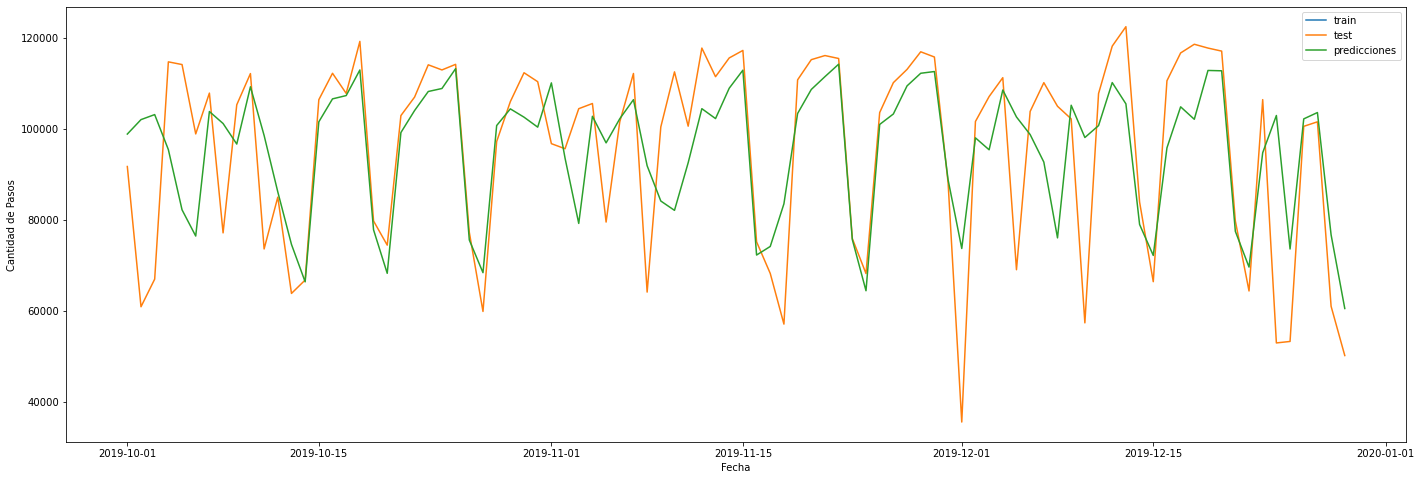

In [111]:
# Gráfico
plt.figure(figsize = (24,8))
plt.plot(diario_ds_corregido_fb_train.loc[diario_ds_corregido_fb_train.index.strftime('%Y-%m-%d')>='2019-08-01'].index, diario_ds_corregido_fb_train.loc[diario_ds_corregido_fb_train.index.strftime('%Y-%m-%d')>='2019-08-01'].cantidad_pasos, label = 'train')
plt.plot(diario_ds_corregido_fb_test.index, diario_ds_corregido_fb_test.cantidad_pasos, label = 'test')
plt.plot(prediccionesb.index, prediccionesb.cantidad_pasos, label = 'predicciones')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

In [112]:
#Calculamos la raíz del error cuadratico medio (rmse) para train y test
rmse_test_tree = np.sqrt(mean_squared_error(diario_ds_corregido_fb_test.loc[:"2019-12-30"].cantidad_pasos, prediccionesb))

#Calculamos el error r2_score
r2_test_tree = r2_score(diario_ds_corregido_fb_test.loc[:"2019-12-30"].cantidad_pasos, prediccionesb)

#Calculamos el MAE
mae_test_tree = mean_absolute_error(diario_ds_corregido_fb_test.loc[:"2019-12-30"].cantidad_pasos, prediccionesb)

print(f'Raíz del error cuadrático medio en Test: {rmse_test_tree}')
print(f'R2 en Test: {r2_test_tree}')
print(f'MAE en Test: {mae_test_tree}')

Raíz del error cuadrático medio en Test: 15440.397884276781
R2 en Test: 0.4759971263820023
MAE en Test: 10837.263222222224


- Como se puede observar existe un mejora, de casi 10 puntos para R2, en las metricas de error al realizar la predicción con el Modelo de Blending sin optimizar.
- Utilizar un técnica combinada de modelos, utilizando Blending, es un camino viable para mejorar la metrica de la predicción del Modelo.


In [113]:
diario_ds_corregido_fb.to_csv('data_blending_tsf.csv')